## Import

In [1]:
import mne
import numpy as np
import scipy
from scipy import signal as sg
from matplotlib import pyplot as plt
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

## Load Data

In [2]:
raw = mne.io.read_raw_brainvision("20231019_B68_stroopv1_0001.vhdr")

# Reconstruct the original events from our Raw object
events, event_ids = mne.events_from_annotations(raw)

Extracting parameters from 20231019_B68_stroopv1_0001.vhdr...
Setting channel info structure...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1']


In [3]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_channel_types({'ECG':'ecg'})
raw.set_channel_types({'vEOG':'eog'})
raw.set_channel_types({'hEOG':'eog'})

<RawBrainVision | 20231019_B68_stroopv1_0001.eeg, 67 x 958600 (958.6 s), ~60 kB, data not loaded>

In [4]:
raw.set_montage(montage)
#fig = raw.plot_sensors(show_names=True)

<RawBrainVision | 20231019_B68_stroopv1_0001.eeg, 67 x 958600 (958.6 s), ~83 kB, data not loaded>

## ECG Analysis

### Using My Pan Tompkins Algorithm

In [5]:
##Testing only on ECG, T = 60 secs
#raw_ecg = raw.copy().pick_types(eeg=False, eog=False, ecg=True).crop(tmin = 60, tmax = 120) #make a copy


#Testing only on ECG, T = Whole experiment actual time
raw_ecg = raw.copy().pick_types(eeg=False, eog=False, ecg=True).crop(tmin = 39.471, tmax = 939.971) #make a copy

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [6]:
fs = 1000
mne_ecg, mne_time = raw_ecg[:]
mne_ecg = -mne_ecg.T

####  Pan Tompkins Alogrithm

In [7]:
class pan_tompkins_qrs():
    def bpf(self,x):
        
        
        
        y_filtered = None

        #Results will be delayed 16 Samples
        y = x.copy()

        #Low Pass Filter
        #y(n) = 2y(n-1) - y(n-2) + x(n) - 2x(n-6) + x(n-12)
        for n in range(len(x)):
            y[n] = x[n]

            if (n >= 1):
                y[n] += 2*y[n-1]
            if (n >= 2):
                y[n] -= y[n-2]
            if (n >= 6):
                y[n] -= 2*x[n-6]
            if (n >= 12):
                y[n] += x[n-12]
        
        y_filtered = y.copy()

        #High Pass Filter
        #y(n) = 32x(n-16) - y(n-1) - x(n) + x(n-32)
        for n in range(len(x)):
            y_filtered[n] = -1*y[n]

            if (n >= 1):
                y_filtered[n] -= y_filtered[n-1]
            if (n >= 16):
                y_filtered[n] += 32*y[n-16]
            if(n >= 32):
                y_filtered[n] += y[n-32]
        
        #Normalization
        max_val = max(max(y_filtered), -min(y_filtered))
        y_filtered = y_filtered/max_val

        return y_filtered
    
    def derivative(self,x,fs):
        
        #Results will be delayed for 2 samples
        y_derived = x.copy()
        
        #Derivative Filter
        #y(n) = [-x(n-2) - 2x(n-1) + 2x(n+1) + x(n+2)]/8
        for n in range(len(x)):
            y_derived[n] = 0

            if (n >= 1):
                y_derived[n] -= 2*x[n-1]
            if (n >= 2):
                y_derived[n] -= x[n-2]
            
            ###Not sure what this part is for###
            if (n >= 2 and n <= len(x)-2):
                y_derived[n] += 2*x[n+1]
            if (n >= 2 and n<= len(x)-3):
                y_derived[n] += x[n+2]
            ###Not sure what this part is for###

            ###Not sure why does it has to be times to "fs"###
            y_derived[n] = (y_derived[n]*fs)/8
            ###Not sure why does it has to be times to "fs"###
        
        return y_derived
    
    def squaring(self,x):
        
        y_squared = x.copy()

        for n in range(len(x)):
            y_squared[n] = x[n]**2

        return y_squared
    
    def moving_window_integration(self,x,fs):
        # Initialize result and window size for integration
        y = x.copy()
        win_size = round(0.150 * fs)
        sum = 0

        # Calculate the sum for the first N terms
        for j in range(win_size):
            sum += x[j]/win_size
            y[j] = sum
        
        # Apply the moving window integration using the equation given
        for n in range(win_size,len(x)):  
            sum += x[n]/win_size
            sum -= x[n-win_size]/win_size
            y[n] = sum

        return y

    def solve(self,x,fs):

        # Convert the input signal into numpy array
        input_signal = x.copy()

        # Bandpass Filter
        global bpass
        bpass = self.bpf(input_signal.copy())

        # Derivative Function
        global der
        der = self.derivative(bpass.copy(),fs)

        # Squaring Function
        global sqr
        sqr = self.squaring(der.copy())

        # Moving Window Integration Function
        global mwin
        mwin = self.moving_window_integration(sqr.copy(),fs)

        return mwin


In [8]:
class heart_rate():
    def __init__(self,x,fs):
        #Initialize Variables
        self.RR1, self.RR2, self.probable_peaks, self.r_locs, self.peaks, self.result = ([] for i in range(6))
        self.SPKI, self.NPKI, self.Threshold_I1, self.Threshold_I2, self.SPKF, self.NPKF, self.Threshold_F1, self.Threshold_F2 = (0 for i in range(8))

        self.T_wave = False
        self.m_win = mwin
        self.b_pass = bpass
        self.fs = fs
        self.signal = x
        self.win_150ms = round(0.15*self.fs)

        self.RR_Low_Limit = 0
        self.RR_High_Limit = 0
        self.RR_Missed_Limit = 0
        self.RR_Average1 = 0

    def approx_peak(self):
        ###Change from the original code by making the size to (A x 1) instead of (A x )###
        slopes = sg.fftconvolve(self.m_win, np.full((25,1),1)/25, mode='same')
        ###Change from the original code by making the size to (A x 1) instead of (A x )###

        # for i in range(round(0.5*self.fs) + 1,len(slopes)-1):
        for i in range(0,len(slopes)-1):
            if (slopes[i] > slopes[i-1]) and (slopes[i+1] <slopes[i]):
                self.peaks.append(i)

    def adjust_rr_interval(self, ind):
        self.RR1 = np.diff(self.peaks[max(0,ind - 8) : ind + 1])/self.fs  

        # Calculating RR Averages
        self.RR_Average1 = np.mean(self.RR1)
        RR_Average2 = self.RR_Average1
        
        # Finding the eight most recent RR intervals lying between RR Low Limit and RR High Limit  
        if (ind >= 8):
            for i in range(0, 8):
                if (self.RR_Low_Limit < self.RR1[i] < self.RR_High_Limit): 
                    self.RR2.append(self.RR1[i])

                    if (len(self.RR2) > 8):
                        self.RR2.remove(self.RR2[0])
                        RR_Average2 = np.mean(self.RR2)    

        # Adjusting the RR Low Limit and RR High Limit
        if (len(self.RR2) > 7 or ind < 8):
            self.RR_Low_Limit = 0.92 * RR_Average2        
            self.RR_High_Limit = 1.16 * RR_Average2
            self.RR_Missed_Limit = 1.66 * RR_Average2
    
    def searchback(self, peak_val, RRn, sb_win):
        # Check if the most recent RR interval is greater than the RR Missed Limit
        if (RRn > self.RR_Missed_Limit):
            # Initialize a window to searchback  
            win_rr = self.m_win[peak_val - sb_win + 1 : peak_val + 1] 

            # Find the x locations inside the window having y values greater than Threshold I1             
            coord = np.asarray(win_rr > self.Threshold_I1).nonzero()[0]

            # Find the x location of the max peak value in the search window
            if (len(coord) > 0):
                for pos in coord:
                    if (win_rr[pos] == max(win_rr[coord])):
                        x_max = pos
                        break
            else:
                x_max = None
    
            # If the max peak value is found
            if (x_max is not None):   
                # Update the thresholds corresponding to moving window integration
                self.SPKI = 0.25 * self.m_win[x_max] + 0.75 * self.SPKI                         
                self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
                self.Threshold_I2 = 0.5 * self.Threshold_I1         

                # Initialize a window to searchback 
                win_rr = self.b_pass[x_max - self.win_150ms: min(len(self.b_pass) -1, x_max)]  

                # Find the x locations inside the window having y values greater than Threshold F1                   
                coord = np.asarray(win_rr > self.Threshold_F1).nonzero()[0]

                # Find the x location of the max peak value in the search window
                if (len(coord) > 0):
                    for pos in coord:
                        if (win_rr[pos] == max(win_rr[coord])):
                            r_max = pos
                            break
                else:
                    r_max = None

                # If the max peak value is found
                if (r_max is not None):
                # Update the thresholds corresponding to bandpass filter
                    if self.b_pass[r_max] > self.Threshold_F2:                                                        
                        self.SPKF = 0.25 * self.b_pass[r_max] + 0.75 * self.SPKF                            
                        self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
                        self.Threshold_F2 = 0.5 * self.Threshold_F1      

                        # Append the probable R peak location                      
                        self.r_locs.append(r_max)

    def find_t_wave(self,peak_val,RRn,ind,prev_ind):
        '''
        T Wave Identification
        :param peak_val: peak location in consideration
        :param RRn: the most recent RR interval
        :param ind: current index in peaks array
        :param prev_ind: previous index in peaks array
        '''

        if (self.m_win[peak_val] >= self.Threshold_I1): 
            if (ind > 0 and 0.20 < RRn < 0.36):
                # Find the slope of current and last waveform detected        
                curr_slope = max(np.diff(self.m_win[peak_val - round(self.win_150ms/2) : peak_val + 1]))
                last_slope = max(np.diff(self.m_win[self.peaks[prev_ind] - round(self.win_150ms/2) : self.peaks[prev_ind] + 1]))
            
                # If current waveform slope is less than half of last waveform slope
                if (curr_slope < 0.5*last_slope):  
                    # T Wave is found and update noise threshold                      
                    self.T_wave = True                             
                    self.NPKI = 0.125 * self.m_win[peak_val] + 0.875 * self.NPKI 

            if (not self.T_wave):
                # T Wave is not found and update signal thresholds
                if (self.probable_peaks[ind] > self.Threshold_F1):   
                    self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI                                         
                    self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

                    # Append the probable R peak location
                    self.r_locs.append(self.probable_peaks[ind])  

                else:
                    self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI
                    self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                   

        # Update noise thresholds
        elif (self.m_win[peak_val] < self.Threshold_I1) or (self.Threshold_I1 < self.m_win[peak_val] < self.Threshold_I2):
            self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


    def adjust_thresholds(self,peak_val,ind):
        '''
        Adjust Noise and Signal Thresholds During Learning Phase
        :param peak_val: peak location in consideration
        :param ind: current index in peaks array
        '''

        if (self.m_win[peak_val] >= self.Threshold_I1): 
            # Update signal threshold
            self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI

            if (self.probable_peaks[ind] > self.Threshold_F1):                                            
                self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

                # Append the probable R peak location
                self.r_locs.append(self.probable_peaks[ind])  

            else:
                # Update noise threshold
                self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                                    
            
        # Update noise thresholds    
        elif (self.m_win[peak_val] < self.Threshold_I2) or (self.Threshold_I2 < self.m_win[peak_val] < self.Threshold_I1):
            self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


    def update_thresholds(self):
        '''
        Update Noise and Signal Thresholds for next iteration
        '''

        self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
        self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
        self.Threshold_I2 = 0.5 * self.Threshold_I1 
        self.Threshold_F2 = 0.5 * self.Threshold_F1
        self.T_wave = False 


    def ecg_searchback(self):
        '''
        Searchback in ECG signal to increase efficiency
        '''

        # Filter the unique R peak locations
        self.r_locs = np.unique(np.array(self.r_locs).astype(int))

        # Initialize a window to searchback
        win_200ms = round(0.2*self.fs)
    
        for r_val in self.r_locs:
            coord = np.arange(r_val - win_200ms, min(len(self.signal), r_val + win_200ms + 1), 1)

            # Find the x location of the max peak value
            if (len(coord) > 0):
                for pos in coord:
                    if (self.signal[pos] == max(self.signal[coord])):
                        x_max = pos
                        break
            else:
                x_max = None

            # Append the peak location
            if (x_max is not None):   
                self.result.append(x_max)


    def find_r_peaks(self):
        '''
        R Peak Detection
        '''

        # Find approximate peak locations
        self.approx_peak()

        # Iterate over possible peak locations
        for ind in range(len(self.peaks)):

            # Initialize the search window for peak detection
            peak_val = self.peaks[ind]
            win_300ms = np.arange(max(0, self.peaks[ind] - self.win_150ms), min(self.peaks[ind] + self.win_150ms, len(self.b_pass)-1), 1)
            max_val = max(self.b_pass[win_300ms], default = 0)

            # Find the x location of the max peak value
            if (max_val != 0):        
                x_coord = np.asarray(self.b_pass == max_val).nonzero()
                self.probable_peaks.append(x_coord[0][0])
                
            if (ind < len(self.probable_peaks) and ind != 0):
                # Adjust RR interval and limits
                self.adjust_rr_interval(ind)
                
                # Adjust thresholds in case of irregular beats
                if (self.RR_Average1 < self.RR_Low_Limit or self.RR_Average1 > self.RR_Missed_Limit): 
                    self.Threshold_I1 /= 2
                    self.Threshold_F1 /= 2

                RRn = self.RR1[-1]

                # Searchback
                self.searchback(peak_val,RRn,round(RRn*self.fs))

                # T Wave Identification
                self.find_t_wave(peak_val,RRn,ind,ind-1)

            else:
                # Adjust threholds
                self.adjust_thresholds(peak_val,ind)

            # Update threholds for next iteration
            self.update_thresholds()

        # Searchback in ECG signal 
        self.ecg_searchback()

        return self.result


#### Utilization of the Pan Tompkins Algorithm

In [9]:
QRS_detector = pan_tompkins_qrs()
output = QRS_detector.solve(mne_ecg, fs)

C:\Users\jeje_\AppData\Local\Temp\ipykernel_5372\2487238089.py:115: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  curr_slope = max(np.diff(self.m_win[peak_val - round(self.win_150ms/2) : peak_val + 1]))
C:\Users\jeje_\AppData\Local\Temp\ipykernel_5372\2487238089.py:116: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  last_slope = max(np.diff(self.m_win[self.peaks[prev_ind] - round(self.win_150ms/2) : self.peaks[prev_ind] + 1]))
C:\Users\jeje_\AppData\Local\Temp\ipykernel_5372\2487238089.py:119: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (curr_slope < 0.5*last_s

Heart Rate 64.2591183889178 BPM


Text(0.5, 1.0, 'R Peak Locations')

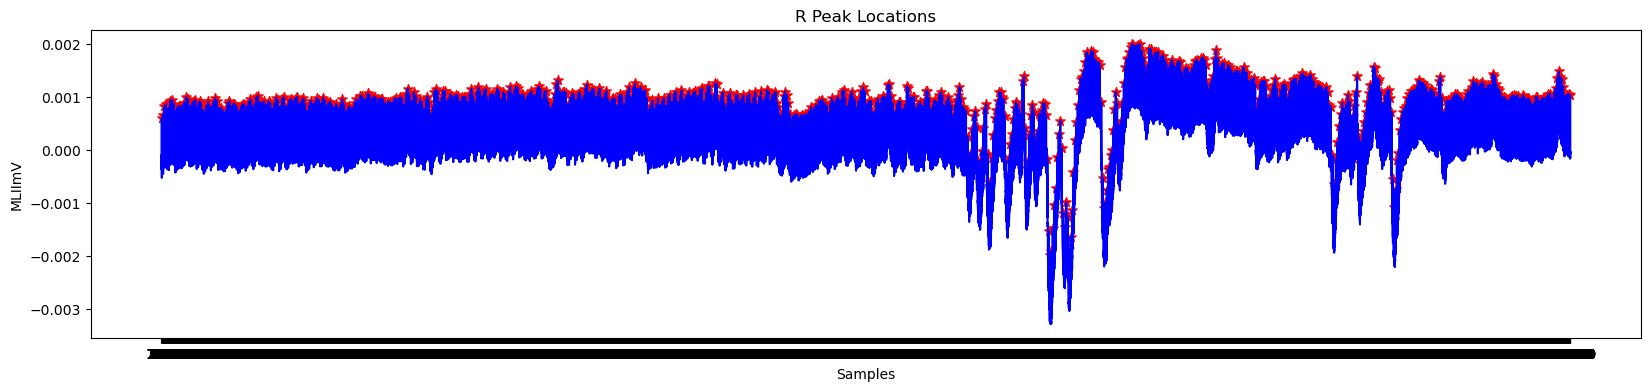

In [10]:
# Convert ecg signal to numpy array
signal = mne_ecg.copy()

# Find the R peak locations
hr = heart_rate(signal,fs)
result = hr.find_r_peaks()
result = np.array(result)

# Clip the x locations less than 0 (Learning Phase)
result = result[result > 0]

# Calculate the heart rate
heartRate = (60*fs)/np.average(np.diff(result[1:]))
print("Heart Rate",heartRate, "BPM")

# Plotting the R peak locations in ECG signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(signal)+1, 150))
plt.plot(signal, color = 'blue')        
plt.scatter(result, signal[result], color = 'red', s = 50, marker= '*')
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("R Peak Locations")

In [11]:
#Find R-Peak and RRI
r_peak = np.unique(result)
rri = r_peak.copy()
rri[1:] = rri[1:] - rri[:-1]

#### Data Interpolation and STFT

Text(0.5, 0, 'Time [sec]')

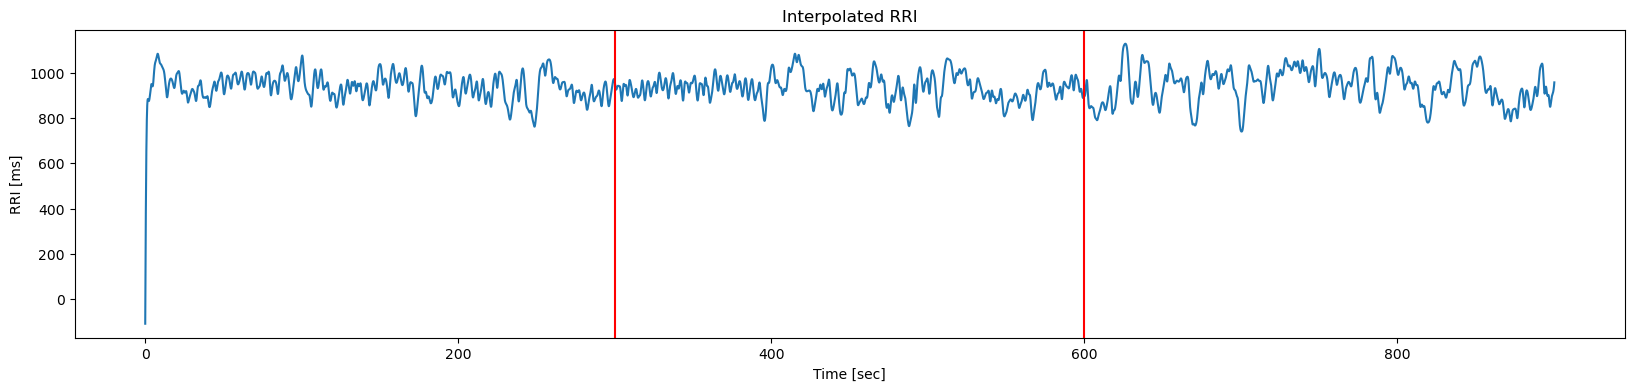

In [12]:
#Data Interpolation, Fs = 1000
exp_duration = len(mne_ecg)/fs

x_vals = np.linspace(0,r_peak[-1],int(exp_duration*fs))
splines = scipy.interpolate.splrep(r_peak,rri)
y_vals = scipy.interpolate.splev(x_vals,splines)

plt.figure(figsize = (20,4),dpi = 100)
plt.plot(x_vals/1000,y_vals)
plt.axvline(x = 300, color = 'r')
plt.axvline(x = 600, color = 'r')

plt.title('Interpolated RRI')
plt.ylabel('RRI [ms]')
plt.xlabel('Time [sec]')


#### Frequency Analysis

In [13]:
y_firstrest = y_vals[0:300000]
y_stress = y_vals[300001:600000]
y_secondrest = y_vals[600001:900000]

##### PSD Measurement using Welch Method

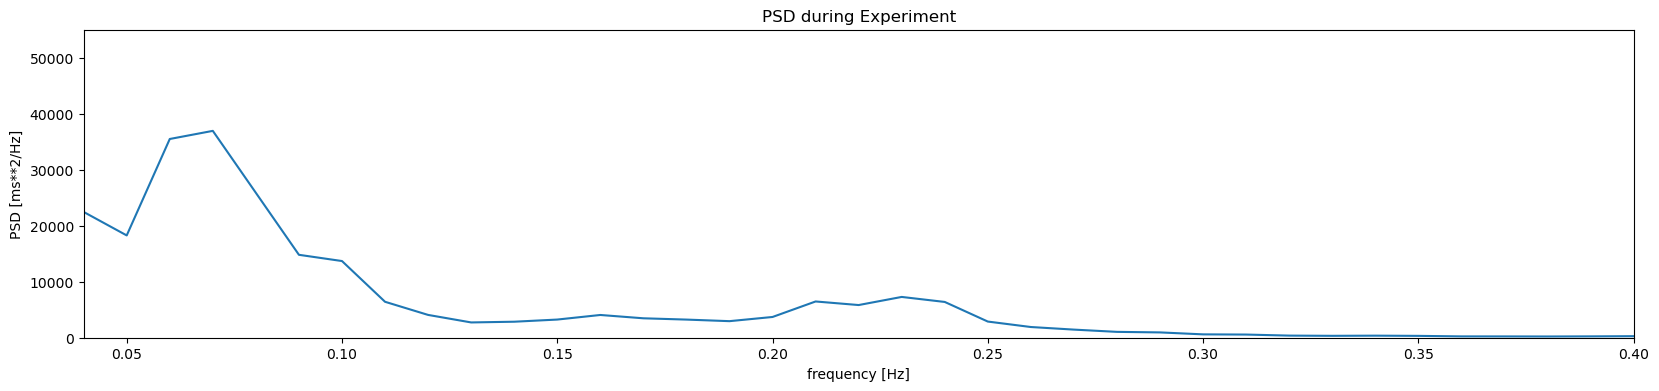

Absolute Power LF =  186811.20659793512 ms**2/Hz
Absolute Power HF =  58671.84394431678 ms**2/Hz
Total Power =  366969.6177886526 ms**2/Hz
LF/HF Ratio =  3.1840009455852547
Normalized Power LF =  50.906450436865484 %
Normalized Power HF =  15.988202047317015 %
Normalized LF/HF Ratio =  3.1840009455852547 %


In [14]:
nperseg = 100000
noverlap = nperseg*2/3

f_den, Pxx_den = sg.welch(y_vals,fs,nperseg = nperseg, noverlap=noverlap)

idx_lf = np.where((0.04 <= f_den) & (f_den <= 0.15))
idx_hf = np.where((0.15 <= f_den) & (f_den <= 0.40))
idx_lfhf = np.where((0.04 <= f_den) & (f_den <= 0.40))
idx_tot_power = np.where((0 <= f_den) & (f_den <= 0.40))

plt.figure(figsize = (20,4), dpi = 100)
plt.plot(f_den, Pxx_den)
plt.xlim(0.04, 0.4)
plt.ylim(bottom=0)
plt.title('PSD during Experiment')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [ms**2/Hz]')
plt.show()

abs_power_LF = np.sum(np.abs(Pxx_den[idx_lf]))
abs_power_HF = np.sum(np.abs(Pxx_den[idx_hf]))
tot_power = np.sum(np.abs(Pxx_den[idx_tot_power]))

print('Absolute Power LF = ', abs_power_LF, 'ms**2/Hz')
print('Absolute Power HF = ',  abs_power_HF, 'ms**2/Hz')
print('Total Power = ', tot_power, 'ms**2/Hz' )

lf_hf_ratio = abs_power_LF/abs_power_HF
print('LF/HF Ratio = ', lf_hf_ratio)

norm_power_LF = (abs_power_LF/tot_power)*100
norm_power_HF = (abs_power_HF/tot_power)*100
norm_lf_hf_ratio = norm_power_LF/norm_power_HF
print('Normalized Power LF = ', norm_power_LF, '%')
print('Normalized Power HF = ',  norm_power_HF, '%')
print('Normalized LF/HF Ratio = ', norm_lf_hf_ratio, '%')

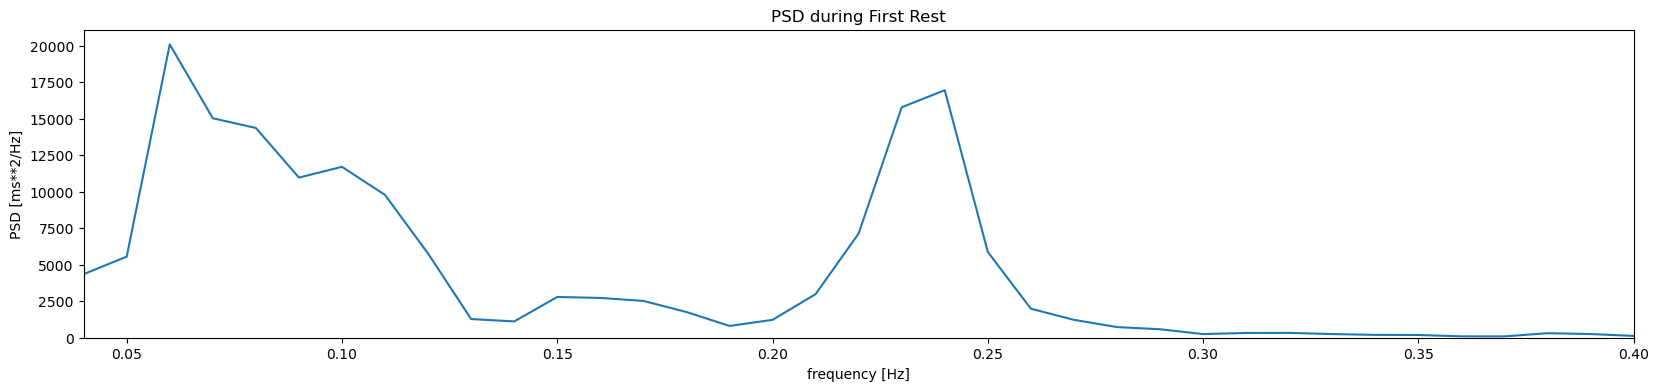

Absolute Power LF =  102777.65655490966 ms**2/Hz
Absolute Power HF =  67485.61971857777 ms**2/Hz
Total Power =  216244.89342661653 ms**2/Hz
LF/HF Ratio =  1.5229564014304595
Normalized Power LF =  47.528362370225224 %
Normalized Power HF =  31.207959942637558 %
Normalized LF/HF Ratio =  1.5229564014304595 %


In [15]:
nperseg = 100000
noverlap = nperseg*2/3

f_den, Pxx_den = sg.welch(y_firstrest,fs,nperseg = nperseg, noverlap=noverlap)

idx_lf = np.where((0.04 <= f_den) & (f_den <= 0.15))
idx_hf = np.where((0.15 <= f_den) & (f_den <= 0.40))
idx_lfhf = np.where((0.04 <= f_den) & (f_den <= 0.40))
idx_tot_power = np.where((0 <= f_den) & (f_den <= 0.40))

plt.figure(figsize = (20,4), dpi = 100)
plt.plot(f_den, Pxx_den)
plt.xlim(0.04, 0.4)
plt.ylim(bottom=0)
plt.title('PSD during First Rest')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [ms**2/Hz]')
plt.show()

abs_power_LF = np.sum(np.abs(Pxx_den[idx_lf]))
abs_power_HF = np.sum(np.abs(Pxx_den[idx_hf]))
tot_power = np.sum(np.abs(Pxx_den[idx_tot_power]))

print('Absolute Power LF = ', abs_power_LF, 'ms**2/Hz')
print('Absolute Power HF = ',  abs_power_HF, 'ms**2/Hz')
print('Total Power = ', tot_power, 'ms**2/Hz' )

lf_hf_ratio = abs_power_LF/abs_power_HF
print('LF/HF Ratio = ', lf_hf_ratio)

norm_power_LF = (abs_power_LF/tot_power)*100
norm_power_HF = (abs_power_HF/tot_power)*100
norm_lf_hf_ratio = norm_power_LF/norm_power_HF
print('Normalized Power LF = ', norm_power_LF, '%')
print('Normalized Power HF = ',  norm_power_HF, '%')
print('Normalized LF/HF Ratio = ', norm_lf_hf_ratio, '%')

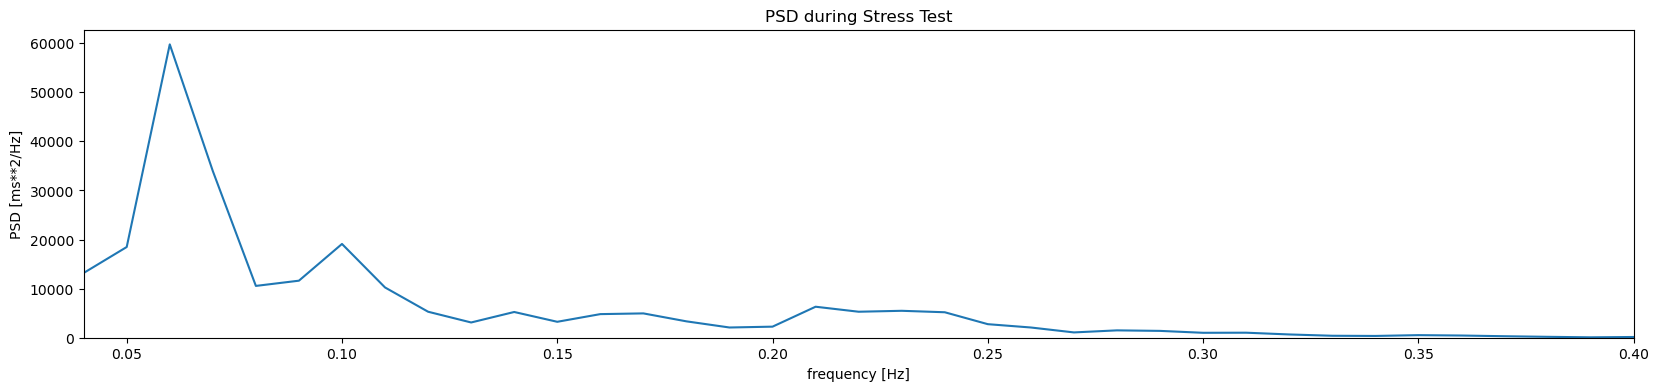

Absolute Power LF =  193761.8106537268 ms**2/Hz
Absolute Power HF =  56922.06934107595 ms**2/Hz
Total Power =  360112.40020820865 ms**2/Hz
LF/HF Ratio =  3.4039839537932073
Normalized Power LF =  53.80592574476697 %
Normalized Power HF =  15.806750700105002 %
Normalized LF/HF Ratio =  3.403983953793207 %


In [16]:
nperseg = 100000
noverlap = nperseg*2/3

f_den, Pxx_den = sg.welch(y_stress,fs,nperseg = nperseg, noverlap=noverlap)
plt.figure(figsize = (20,4), dpi = 100)
plt.plot(f_den, Pxx_den)
plt.xlim(0.04, 0.4)
plt.ylim(bottom=0)
plt.title('PSD during Stress Test')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [ms**2/Hz]')
plt.show()

idx_lf = np.where((0.04 <= f_den) & (f_den <= 0.15))
idx_hf = np.where((0.15 <= f_den) & (f_den <= 0.40))
idx_lfhf = np.where((0.04 <= f_den) & (f_den <= 0.40))
idx_tot_power = np.where((0 <= f_den) & (f_den <= 0.40))

abs_power_LF = np.sum(np.abs(Pxx_den[idx_lf]))
abs_power_HF = np.sum(np.abs(Pxx_den[idx_hf]))
tot_power = np.sum(np.abs(Pxx_den[idx_tot_power]))

print('Absolute Power LF = ', abs_power_LF, 'ms**2/Hz')
print('Absolute Power HF = ',  abs_power_HF, 'ms**2/Hz')
print('Total Power = ', tot_power, 'ms**2/Hz' )

lf_hf_ratio = abs_power_LF/abs_power_HF
print('LF/HF Ratio = ', lf_hf_ratio)

norm_power_LF = (abs_power_LF/tot_power)*100
norm_power_HF = (abs_power_HF/tot_power)*100
norm_lf_hf_ratio = norm_power_LF/norm_power_HF
print('Normalized Power LF = ', norm_power_LF, '%')
print('Normalized Power HF = ',  norm_power_HF, '%')
print('Normalized LF/HF Ratio = ', norm_lf_hf_ratio, '%')

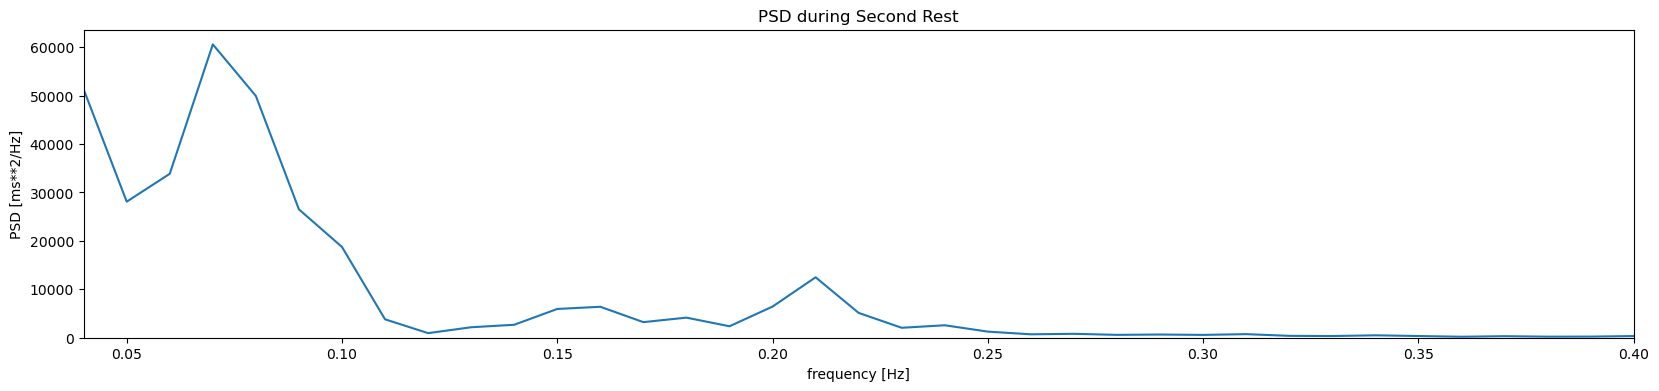

Absolute Power LF =  284481.2277564308 ms**2/Hz
Absolute Power HF =  58949.64484502518 ms**2/Hz
Total Power =  482325.5991131177 ms**2/Hz
LF/HF Ratio =  4.825834464385895
Normalized Power LF =  58.98115884363679 %
Normalized Power HF =  12.221960632696996 %
Normalized LF/HF Ratio =  4.825834464385894 %


In [17]:
nperseg = 100000
noverlap = nperseg*2/3

f_den, Pxx_den = sg.welch(y_secondrest,fs,nperseg = nperseg, noverlap=noverlap)
plt.figure(figsize = (20,4), dpi = 100)
plt.plot(f_den, Pxx_den)
plt.xlim(0.04, 0.4)
plt.ylim(bottom=0)
plt.title('PSD during Second Rest')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [ms**2/Hz]')
plt.show()

idx_lf = np.where((0.04 <= f_den) & (f_den <= 0.15))
idx_hf = np.where((0.15 <= f_den) & (f_den <= 0.40))
idx_lfhf = np.where((0.04 <= f_den) & (f_den <= 0.40))
idx_tot_power = np.where((0 <= f_den) & (f_den <= 0.40))

abs_power_LF = np.sum(np.abs(Pxx_den[idx_lf]))
abs_power_HF = np.sum(np.abs(Pxx_den[idx_hf]))
tot_power = np.sum(np.abs(Pxx_den[idx_tot_power]))

print('Absolute Power LF = ', abs_power_LF, 'ms**2/Hz')
print('Absolute Power HF = ',  abs_power_HF, 'ms**2/Hz')
print('Total Power = ', tot_power, 'ms**2/Hz' )

lf_hf_ratio = abs_power_LF/abs_power_HF
print('LF/HF Ratio = ', lf_hf_ratio)

norm_power_LF = (abs_power_LF/tot_power)*100
norm_power_HF = (abs_power_HF/tot_power)*100
norm_lf_hf_ratio = norm_power_LF/norm_power_HF
print('Normalized Power LF = ', norm_power_LF, '%')
print('Normalized Power HF = ',  norm_power_HF, '%')
print('Normalized LF/HF Ratio = ', norm_lf_hf_ratio, '%')

In [18]:
import math

# Parameters for segmentation and analysis
segment_length = 10*fs  # seconds
overlap = int(segment_length*0.9)  # seconds

# Calculate LF/HF ratio over time
lfhf_ratio = []
hf_over_time = []
lf_over_time = []

for i in range(0, len(y_vals), segment_length - overlap):
    segment = y_vals[i:i + segment_length]

    # Compute PSD using Welch's method
    f_den, Pxx_den = sg.welch(segment, fs=fs, nperseg = 10000)

    idx_lf = np.where((0.04 <= f_den) & (f_den <= 0.15))
    idx_hf = np.where((0.15 <= f_den) & (f_den <= 0.40))

    # Calculate LF and HF power
    abs_power_LF = np.sum(np.abs(Pxx_den[idx_lf]))
    abs_power_HF = np.sum(np.abs(Pxx_den[idx_hf]))
    lf_hf_ratio = abs_power_LF / abs_power_HF

    # Calculate LF/HF ratio
    if math.isnan(lf_hf_ratio) == False:
        lfhf_ratio.append(lf_hf_ratio)
    if math.isnan(abs_power_HF) == False:
        hf_over_time.append(abs_power_HF)
    if math.isnan(abs_power_LF) == False:
        lf_over_time.append(abs_power_LF)

c:\Users\jeje_\anaconda3\envs\mne\Lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 10000 is greater than input length  = 9501, using nperseg = 9501
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\jeje_\anaconda3\envs\mne\Lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 10000 is greater than input length  = 8501, using nperseg = 8501
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\jeje_\anaconda3\envs\mne\Lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 10000 is greater than input length  = 7501, using nperseg = 7501
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\jeje_\anaconda3\envs\mne\Lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 10000 is greater than input length  = 6501, using nperseg = 6501
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\jeje_\anaconda3\envs\mne\Lib\site-p

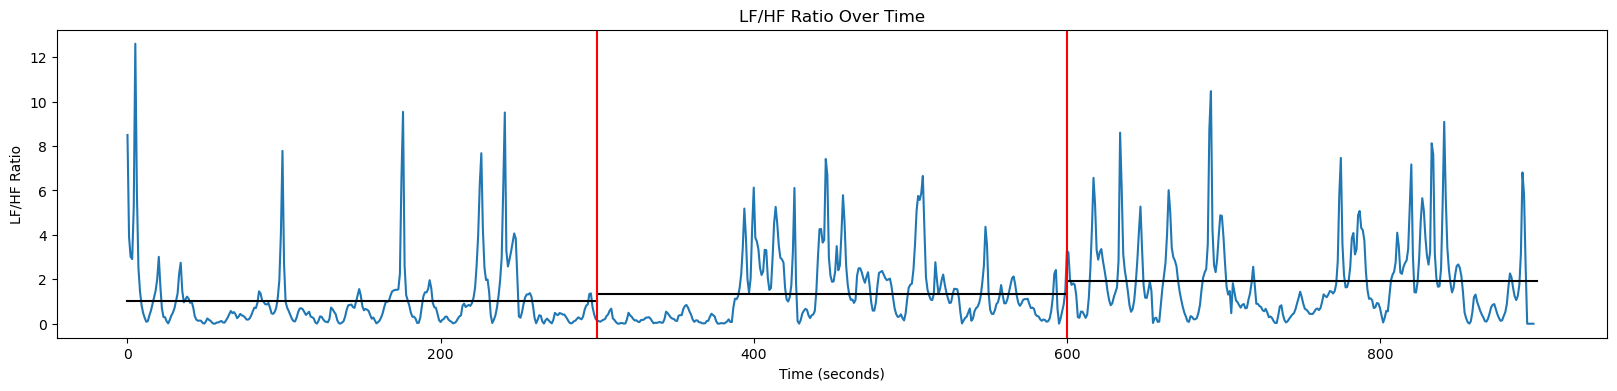

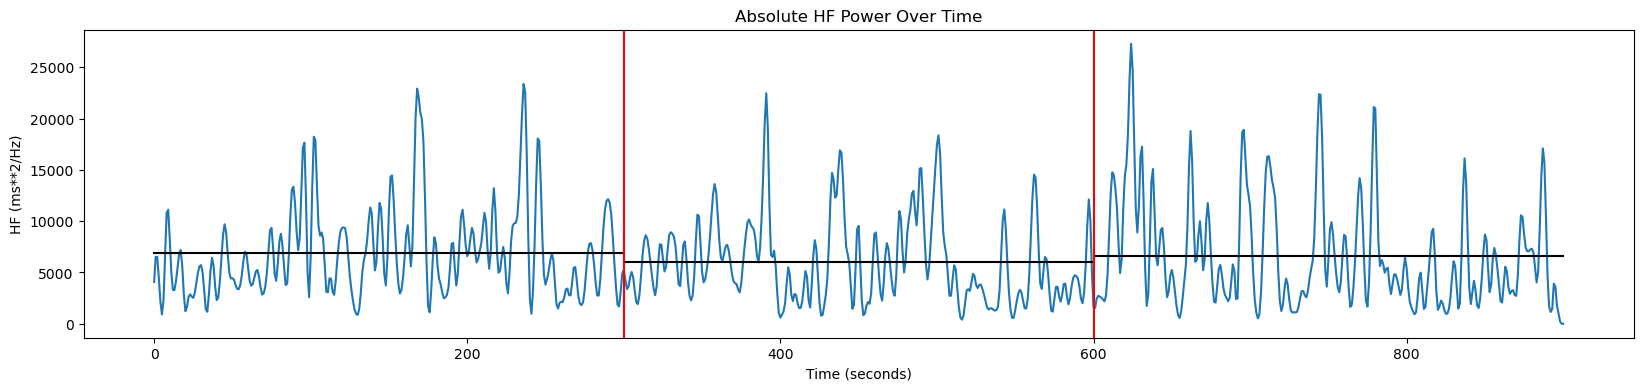

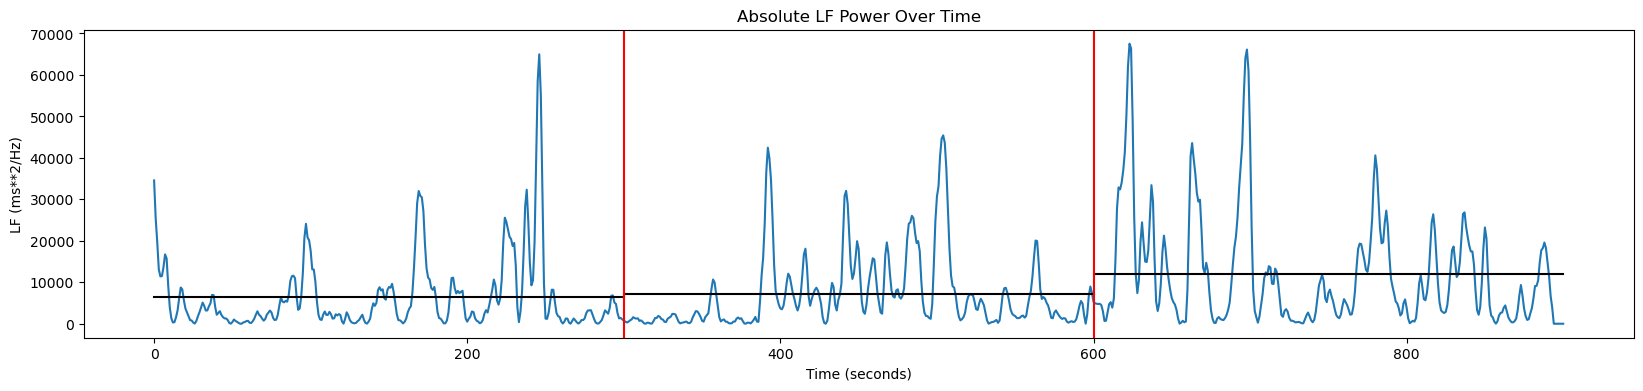

In [19]:
# Plot LF/HF ratio over time
plt.figure(figsize = (20,4))
plt.plot(np.arange(0, len(lfhf_ratio)*(segment_length - overlap), segment_length - overlap)/fs, lfhf_ratio)
plt.plot((0, 300), (np.average(lfhf_ratio[0:300]),np.average(lfhf_ratio[0:300])), 'k-')
plt.plot((300, 600), (np.average(lfhf_ratio[300:600]),np.average(lfhf_ratio[300:600])), 'k-')
plt.plot((600, 900), (np.average(lfhf_ratio[600:]),np.average(lfhf_ratio[600:])), 'k-')
plt.axvline(x = 300, color = 'r')
plt.axvline(x = 600, color = 'r')
plt.xlabel('Time (seconds)')
plt.ylabel('LF/HF Ratio')
plt.title('LF/HF Ratio Over Time')
plt.show()

# Plot HF over time
plt.figure(figsize = (20,4))
plt.plot(np.arange(0, len(hf_over_time)*(segment_length - overlap), segment_length - overlap)/fs, hf_over_time)
plt.plot((0, 300), (np.average(hf_over_time[0:300]),np.average(hf_over_time[0:300])), 'k-')
plt.plot((300, 600), (np.average(hf_over_time[300:600]),np.average(hf_over_time[300:600])), 'k-')
plt.plot((600, 900), (np.average(hf_over_time[600:]),np.average(hf_over_time[600:])), 'k-')
plt.axvline(x = 300, color = 'r')
plt.axvline(x = 600, color = 'r')
plt.xlabel('Time (seconds)')
plt.ylabel('HF (ms**2/Hz)')
plt.title('Absolute HF Power Over Time')
plt.show()

# Plot LF over time
plt.figure(figsize = (20,4))
plt.plot(np.arange(0, len(lf_over_time)*(segment_length - overlap), segment_length - overlap)/fs, lf_over_time)
plt.plot((0, 300), (np.average(lf_over_time[0:300]),np.average(lf_over_time[0:300])), 'k-')
plt.plot((300, 600), (np.average(lf_over_time[300:600]),np.average(lf_over_time[300:600])), 'k-')
plt.plot((600, 900), (np.average(lf_over_time[600:]),np.average(lf_over_time[600:])), 'k-')
plt.axvline(x = 300, color = 'r')
plt.axvline(x = 600, color = 'r')
plt.xlabel('Time (seconds)')
plt.ylabel('LF (ms**2/Hz)')
plt.title('Absolute LF Power Over Time')
plt.show()

##### PSD Measurement using Full FFT

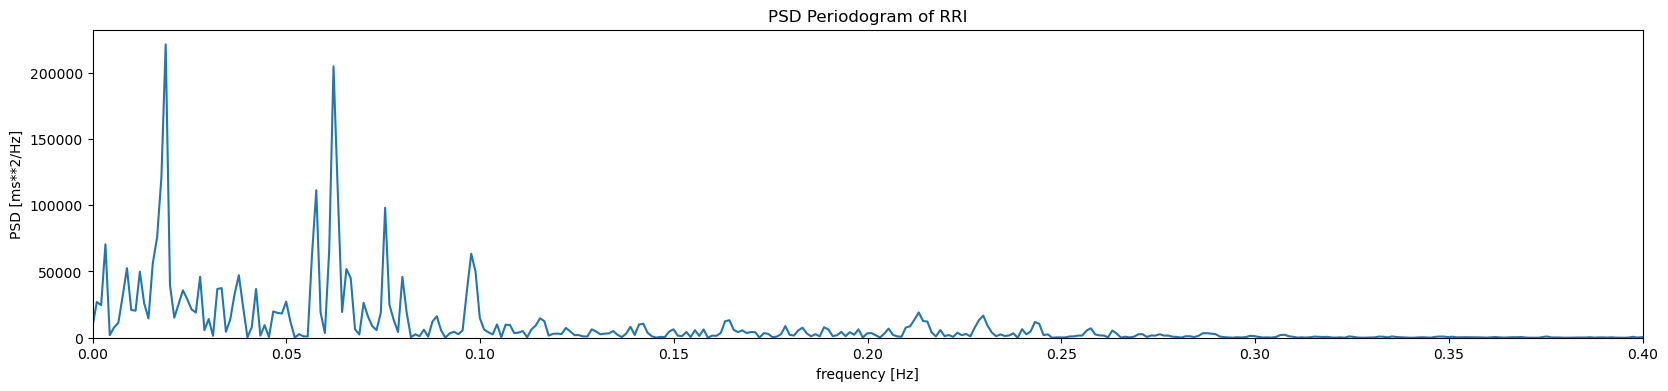

In [20]:
#PSD Measurement using Full FFT
f, Pxx_den = sg.periodogram(y_vals,fs,window = 'hann')
plt.figure(figsize = (20,4), dpi = 100)
plt.plot(f, Pxx_den)
plt.xlim(0, 0.4)
plt.ylim(bottom=0)
plt.title('PSD Periodogram of RRI')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [ms**2/Hz]')
plt.show()

#### Time Analysis

In [21]:
#Measure SDNN
sdnn_full = np.std(y_vals)
sdnn_rest_1 = np.std(y_firstrest)
sdnn_test = np.std(y_stress)
sdnn_rest_2 = np.std(y_secondrest)
print("Standard Deviation during Experiment: ", sdnn_full)
print("Standard Deviation during First Rest: ", sdnn_rest_1)
print("Standard Deviation during CSWT: ", sdnn_test)
print("Standard Deviation during Second Rest: ", sdnn_rest_2)

Standard Deviation during Experiment:  65.31164998571681
Standard Deviation during First Rest:  62.64882131637816
Standard Deviation during CSWT:  55.085880049562476
Standard Deviation during Second Rest:  76.08837679132579


#### Time-Frequency Analysis

##### STFT

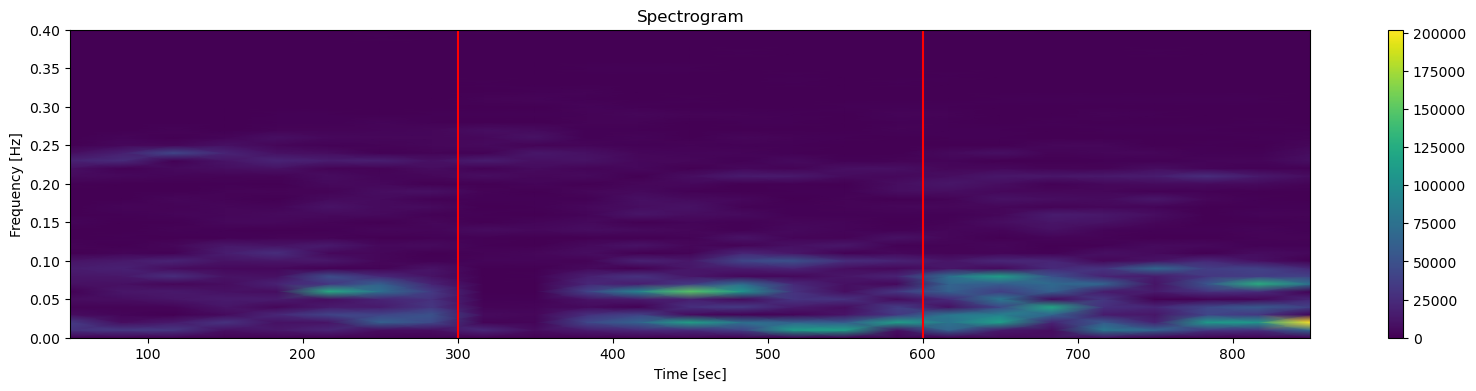

In [22]:
#STFT RRI
nperseg = 100000
noverlap = nperseg*2/3
f1,t1,Sxx = scipy.signal.spectrogram(y_vals, fs=fs, nperseg = nperseg, noverlap = noverlap, scaling='density')
plt.figure(figsize = (20,4), dpi = 100)
plt.pcolormesh(t1, f1, np.abs(Sxx), shading='gouraud', snap= True)
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.axis([t1[0], t1[-1], 0, 0.4])
plt.axvline(x = 300, color = 'r')
plt.axvline(x = 600, color = 'r')
plt.colorbar()
plt.show()

### Using ECG Detectors

## EEG Analysis

In [5]:
#raw_eeg = raw.copy().crop(tmin = 39.471, tmax = 939.971).pick_types(eeg=True, eog=False, ecg=False) #make a copy
# raw_temp_short = raw.copy().crop(tmin=339.471, tmax = 519.471)

raw_temp = raw.copy().crop(tmin = 39.471, tmax = 939.971) #make a copy

# eeg_firstrest = raw.copy().crop(tmin = 39.471, tmax = 339.471)
# eeg_stress = raw.copy().crop(tmin = 339.471, tmax = 639.471)
# eeg_secondrest = raw.copy().crop(tmin = 639.471, tmax = 939.971)

### ICA 

In [6]:
#Regular Expression = Search certain pattern
regexp = r"(ECG|vEOG|hEOG)"
artifact_picks = mne.pick_channels_regexp(raw_temp.ch_names, regexp=regexp)
# raw_temp.plot(order=artifact_picks, n_channels=len(artifact_picks), show_scrollbars=False)

##### Visualizing Artifact

Using EOG channels: vEOG, hEOG
EOG channel index for this subject is: [64 65]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel vEOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 90 significant peaks
Number of EOG events detected: 90
Not setting metadata
90 matching events found
No baseline correction applied
Loading data for 90 events and 1001 original time points ...
1 bad epochs dropped
NOTE: pick_channels() is a legacy fu

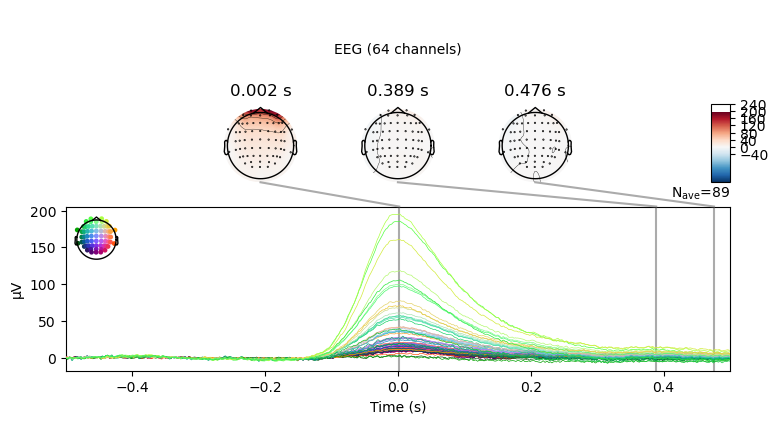

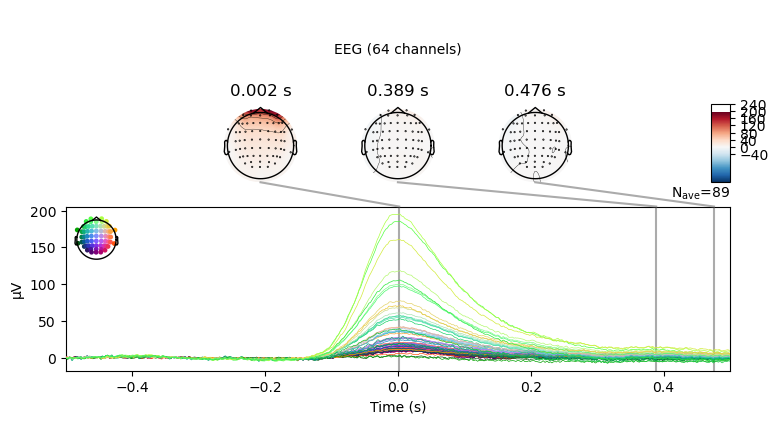

In [25]:
eog_evoked = create_eog_epochs(raw_temp).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 938 (average pulse 62 / min.)
Not setting metadata
938 matching events found
No baseline correction applied
Loading data for 938 events and 1001 original time points ...
1 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function.

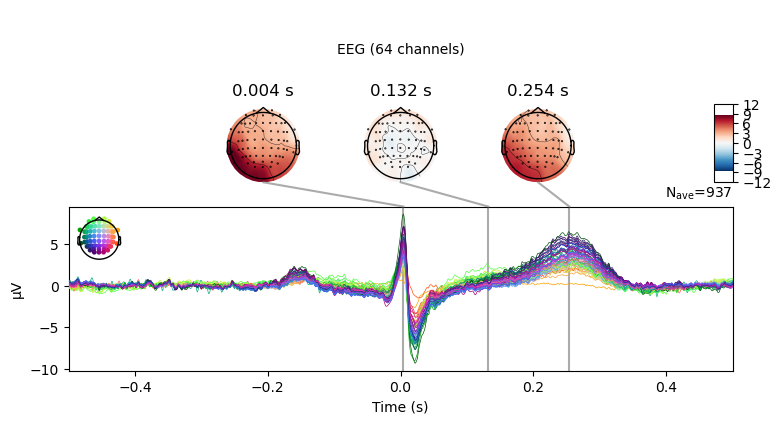

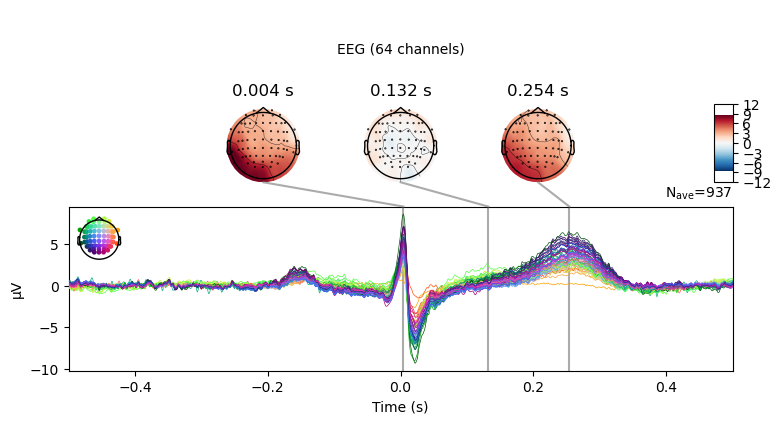

In [26]:
ecg_evoked = create_ecg_epochs(raw_temp).average()
ecg_evoked.apply_baseline(baseline=(None, -0.2))
ecg_evoked.plot_joint()

##### Filtering to Remove Slow Drifts

In [15]:
filt_raw = raw_temp.copy().filter(l_freq=1.0, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


##### Extracting PCA

In [16]:
ica = ICA(n_components=32, max_iter="auto", random_state = 95)
ica.fit(filt_raw)
#ica
#ica.plot_sources(raw_temp, show_scrollbars=False)
#ica.plot_components()

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 39.8s.


Method,fastica
Fit,32 iterations on raw data (900501 samples)
ICA components,32
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


##### Check Blinks PCA

In [17]:
# Remove blinks PCA
eog_indices, eog_scores = ica.find_bads_eog(raw_temp, ch_name=['vEOG', 'hEOG'], threshold = 0.8, measure='correlation')
# ica.plot_overlay(raw_temp, exclude=eog_indices, picks="eeg")
# ica.exclude = eog_indices

# ica.plot_properties(raw_temp, picks=eog_indices)
# ica.plot_scores(eog_scores)

Using EOG channels: vEOG, hEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)



##### Check ECG PCA

In [18]:
#Remove heart beat PCA
ecg_indices, ecg_scores = ica.find_bads_ecg(raw_temp, ch_name='ECG',threshold = 0.8, measure='correlation')
# ica.plot_overlay(raw_temp, exclude=ecg_indices, picks="eeg")
# ica.exclude = ecg_indices

# ica.plot_properties(raw_temp, picks=ecg_indices)
# ica.plot_scores(ecg_scores)

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 938 (average pulse 62 / min.)
Not setting metadata
938 matching events found
No baseline correction applied
Using data from preloaded Raw for 938 events and 1001 original time points ...
1 bad epochs dropped


##### Apply ICA

In [19]:
ica.exclude = ecg_indices,eog_indices

In [20]:
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw_temp.copy()
ica.apply(reconst_raw)

# reconst_raw.plot(title = 'Reconstructed')
# raw_temp.plot(title = 'Raw')

Applying ICA to Raw instance


TypeError: unhashable type: 'list'

In [32]:
#Split After ICA Data into each segments

ica_firstrest = reconst_raw.copy().crop(tmin = 0, tmax = 300)
ica_stress = reconst_raw.copy().crop(tmin = 300, tmax = 600)
ica_secondrest = reconst_raw.copy().crop(tmin = 600)

### Frequency Analysis

In [33]:
alpha_band_raw = raw_temp.copy().filter(l_freq=8, h_freq=13, method='fir', verbose=False)
beta_band_raw = raw_temp.copy().filter(l_freq=13, h_freq=30, method='fir', verbose=False)
gamma_band_raw = raw_temp.copy().filter(l_freq=30, h_freq=40, method='fir', verbose=False)
theta_band_raw = raw_temp.copy().filter(l_freq=4, h_freq=8, method='fir', verbose=False)

In [34]:
alpha_band_reconst = reconst_raw.copy().filter(l_freq=8, h_freq=13, method='fir', verbose=False)
beta_band_reconst = reconst_raw.copy().filter(l_freq=13, h_freq=30, method='fir', verbose=False)
gamma_band_reconst = reconst_raw.copy().filter(l_freq=30, h_freq=40, method='fir', verbose=False)
theta_band_reconst = reconst_raw.copy().filter(l_freq=4, h_freq=8, method='fir', verbose=False)

In [35]:
#Comparison between before and after ICA
theta_band_raw.plot(title = 'Raw')
theta_band_reconst.plot(title = 'Reconstructed')

##### PSD Analysis on EEG

Effective window size : 2.048 (s)


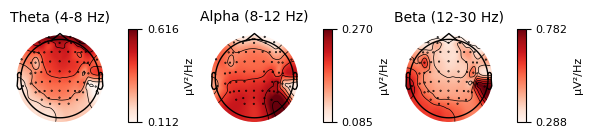

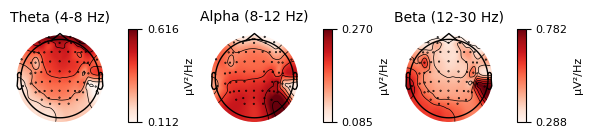

In [36]:
eeg_psd = reconst_raw.compute_psd(method='welch',fmin=4,fmax=30)
eeg_psd.plot_topomap(bands = {'Theta (4-8 Hz)': (4, 8),'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30)}, normalize = True, ch_type='eeg')
#eeg_psd.plot()

Effective window size : 2.048 (s)


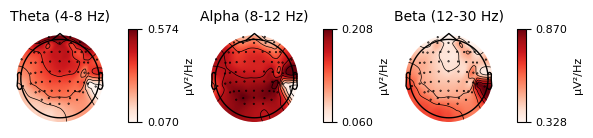

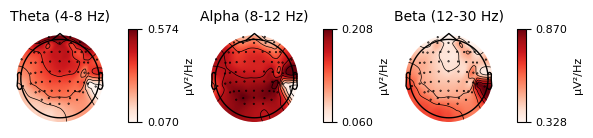

In [37]:
psd_firstrest = ica_firstrest.compute_psd(method='welch',fmin=4,fmax=30)
psd_firstrest.plot_topomap(bands = {'Theta (4-8 Hz)': (4, 8),'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30)}, normalize = True, ch_type='eeg')

Effective window size : 2.048 (s)


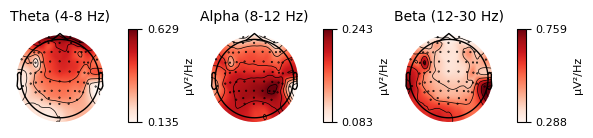

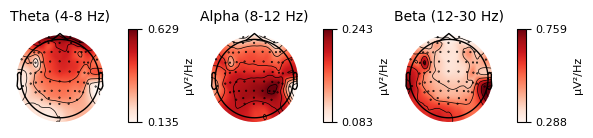

In [38]:
psd_stress = ica_stress.compute_psd(method='welch',fmin=4,fmax=30)
psd_stress.plot_topomap(bands = {'Theta (4-8 Hz)': (4, 8),'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30)}, normalize = True, ch_type='eeg')

Effective window size : 2.048 (s)


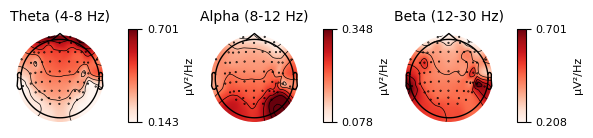

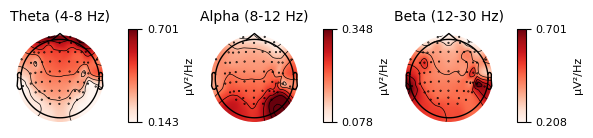

In [39]:
psd_secondrest = ica_secondrest.compute_psd(method='welch',fmin=4,fmax=30)
psd_secondrest.plot_topomap(bands = {'Theta (4-8 Hz)': (4, 8),'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30)}, normalize = True, ch_type='eeg')

In [40]:
epochs = mne.Epochs(reconst_raw,events=events, tmin=-0.2, tmax=1,preload=True)

Not setting metadata
180 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 180 events and 1201 original time points ...
11 bad epochs dropped


In [41]:
epochs = mne.Epochs(reconst_raw,events=events, picks = ['eeg'], reject=None, flat=None, reject_by_annotation=False, tmin=-0.2, tmax=1,preload=True)

Not setting metadata
180 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 180 events and 1201 original time points ...
11 bad epochs dropped


In [42]:
epochs

Number of events,169
Events,1: 16999999: 0
Time range,-0.200 – 1.000 s
Baseline,-0.200 – 0.000 s


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


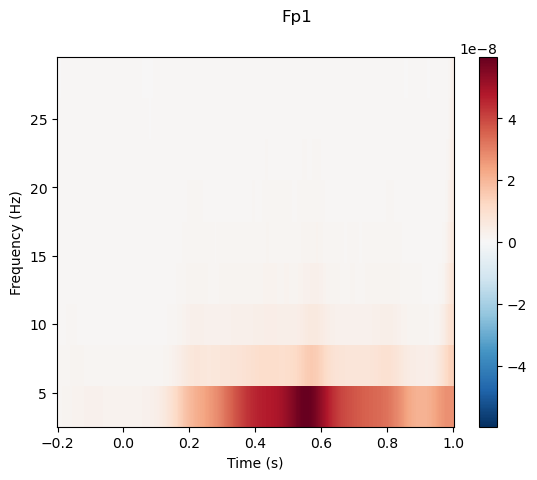

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


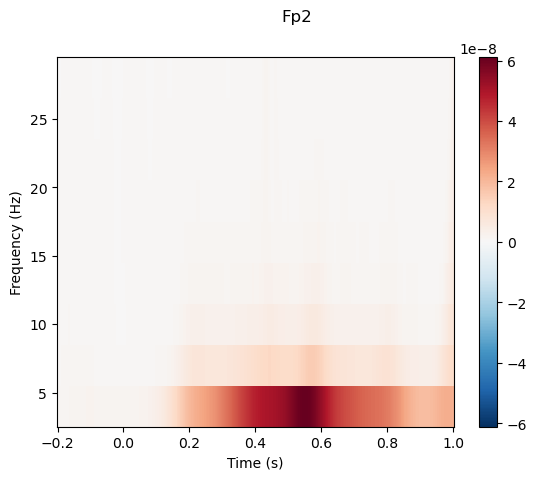

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


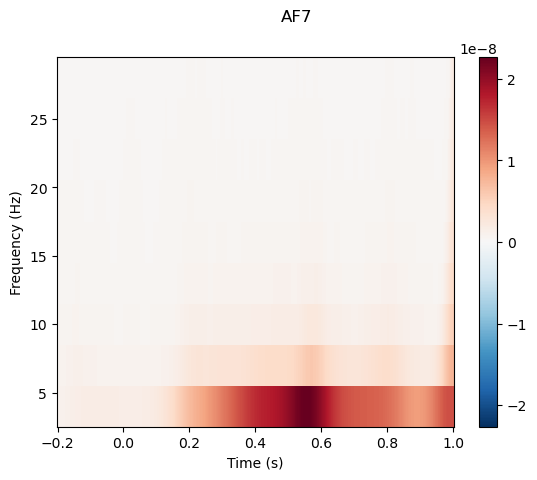

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


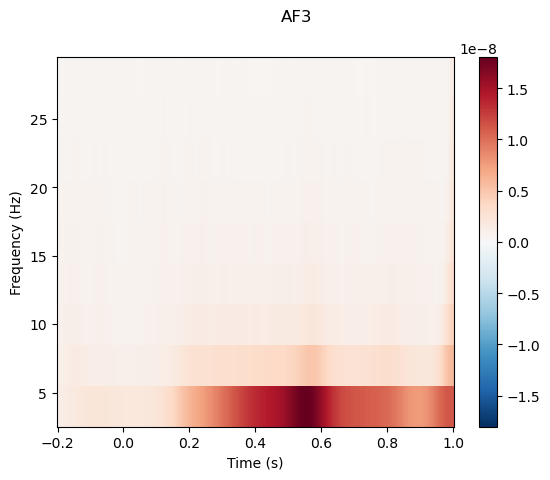

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


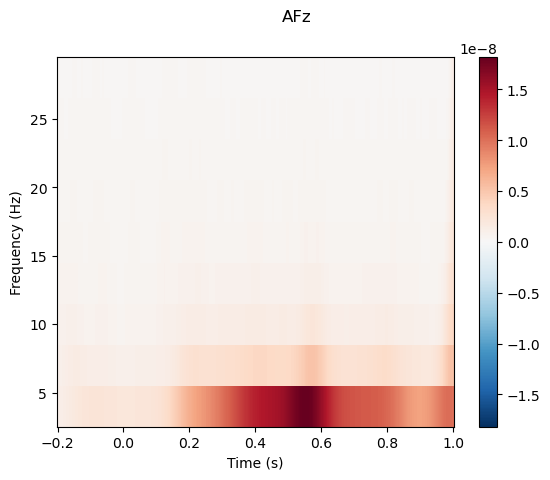

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


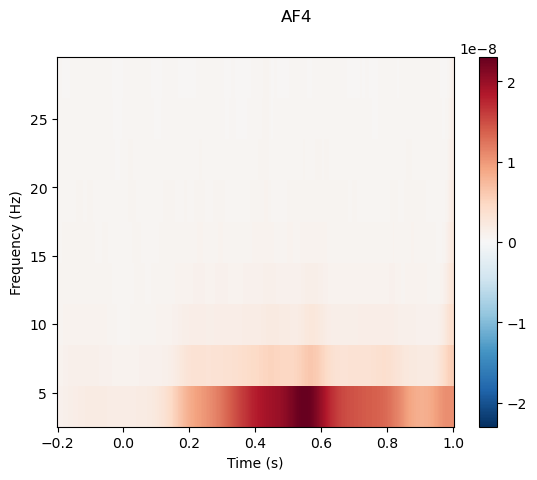

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


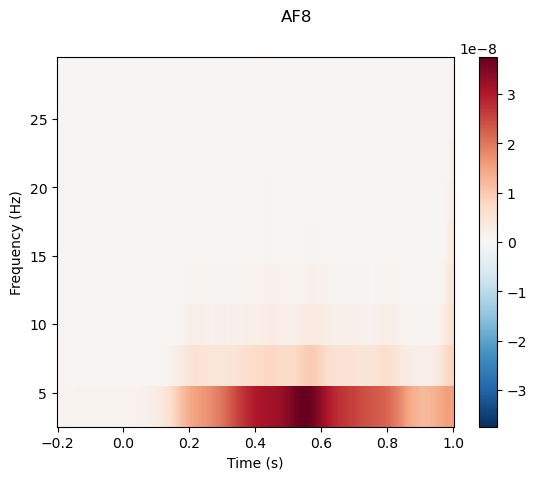

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


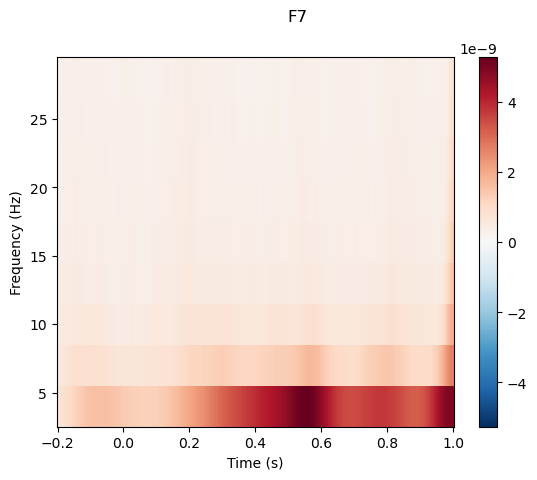

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


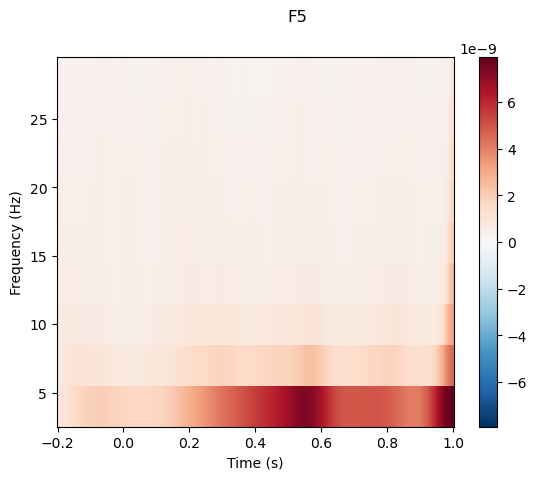

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


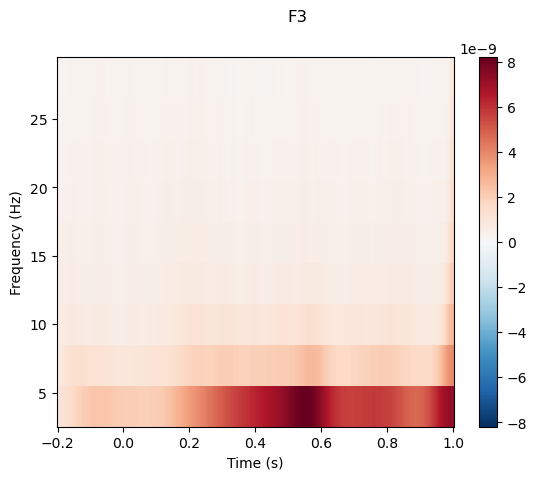

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


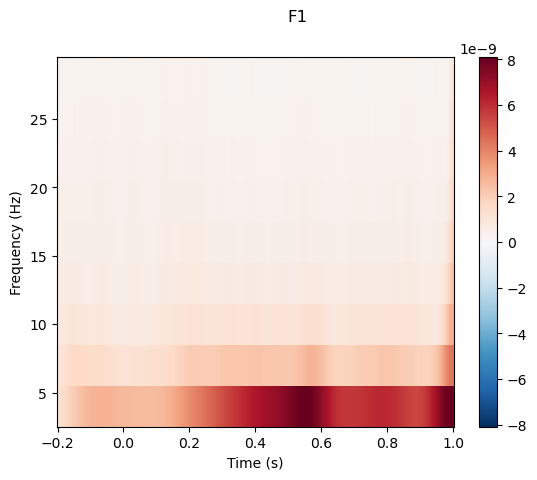

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


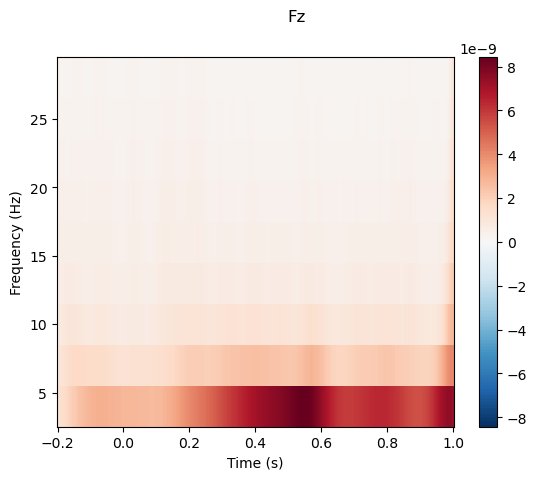

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


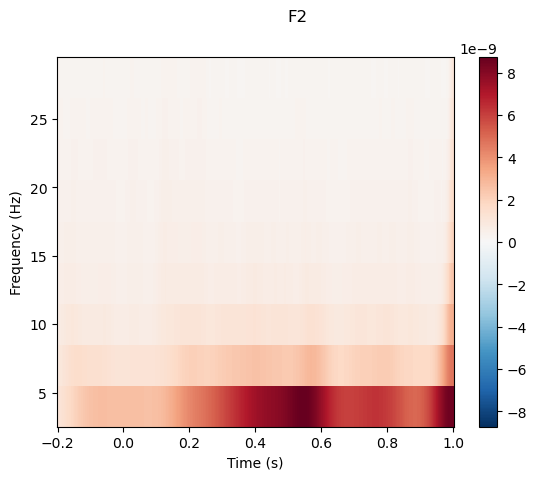

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


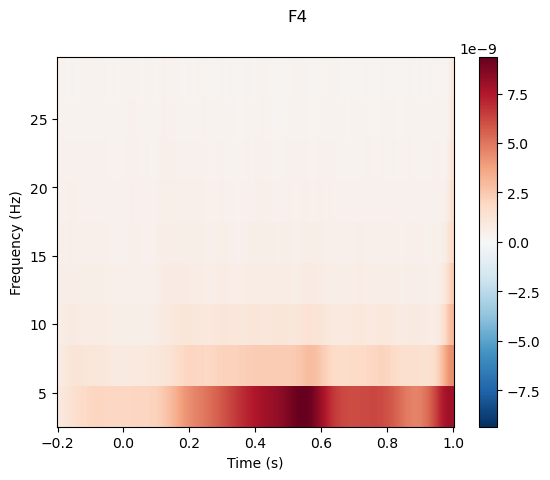

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


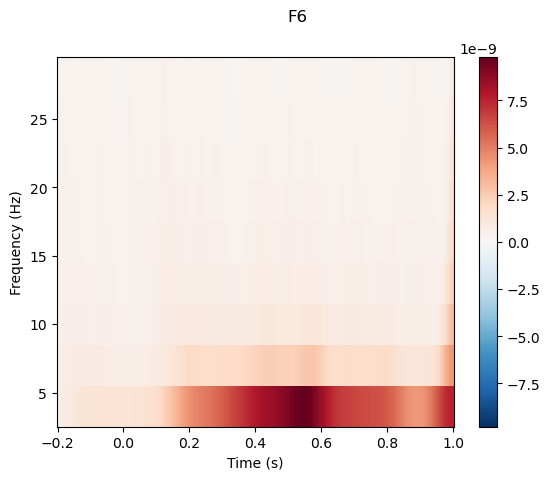

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


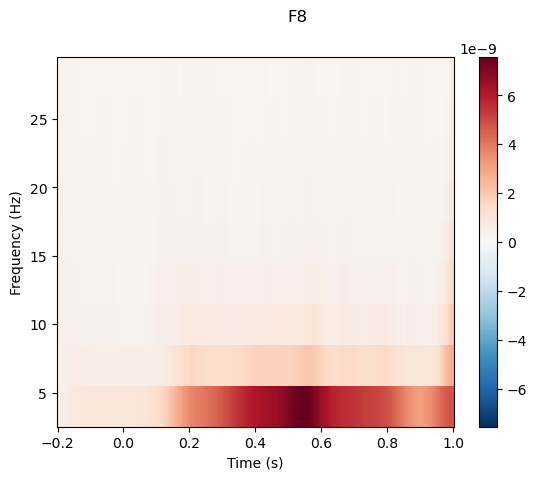

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


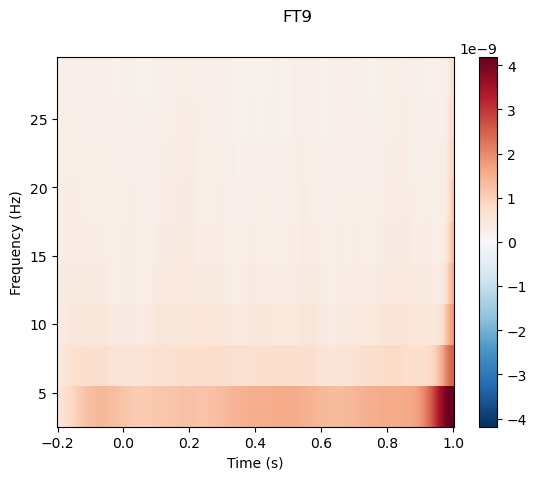

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


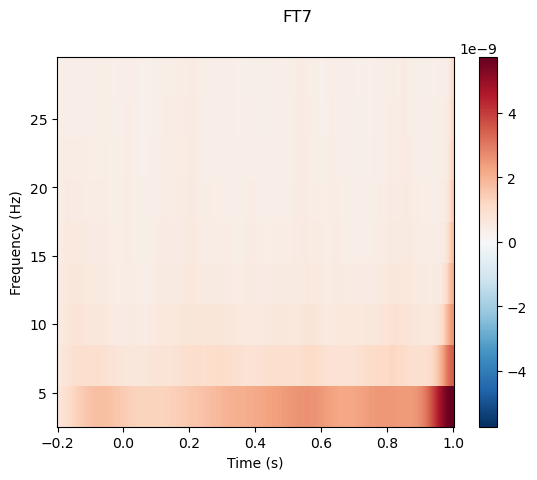

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


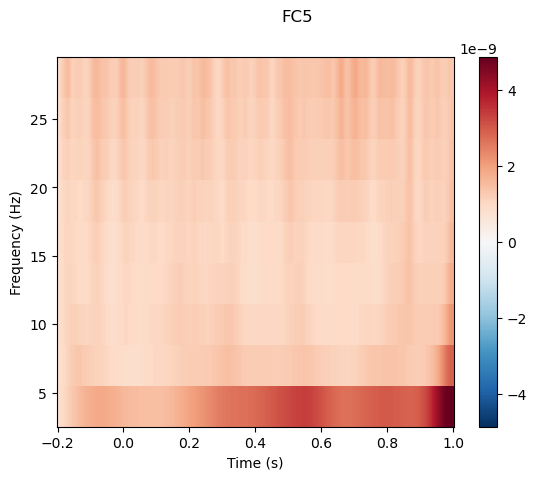

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


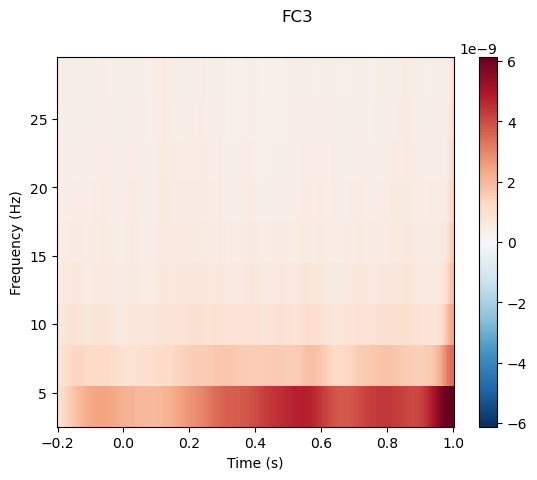

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


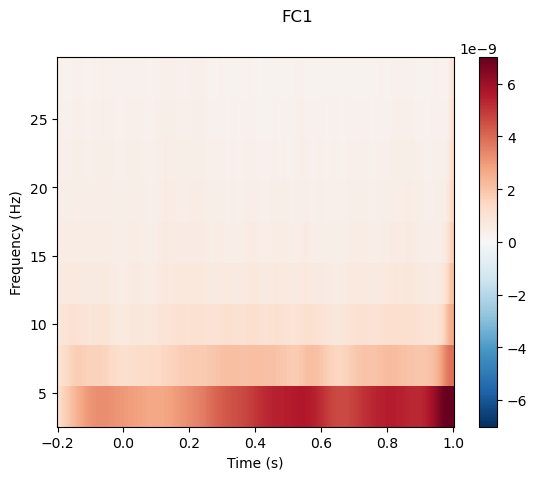

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


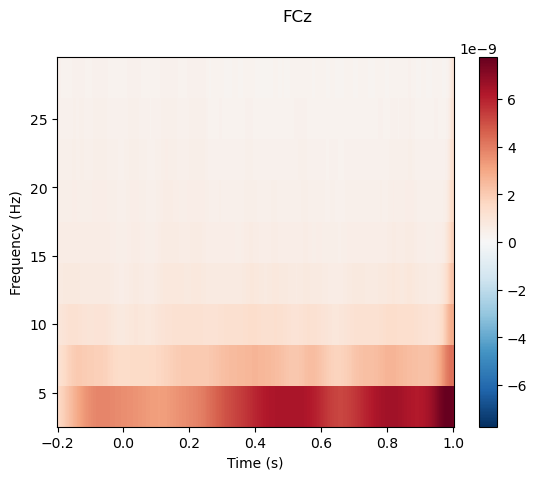

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


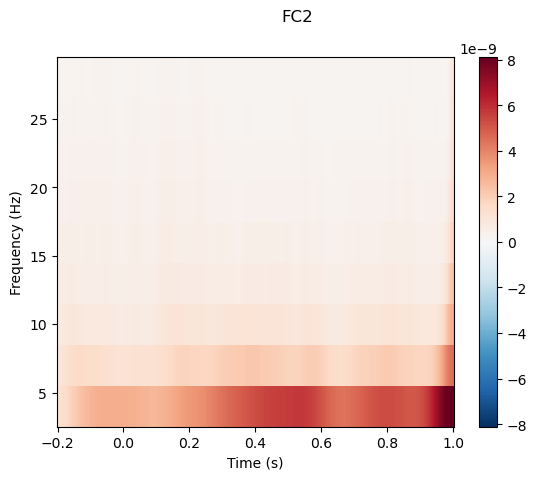

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


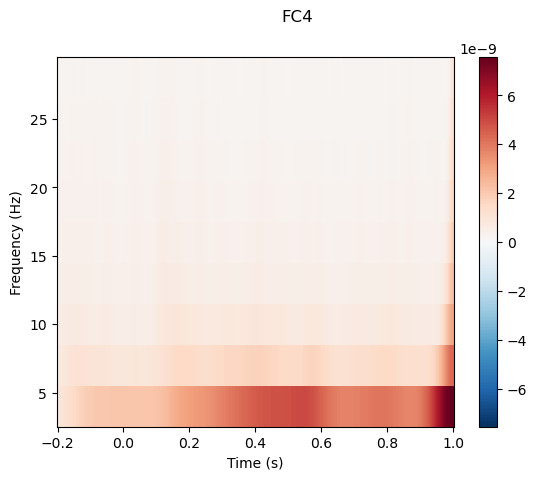

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


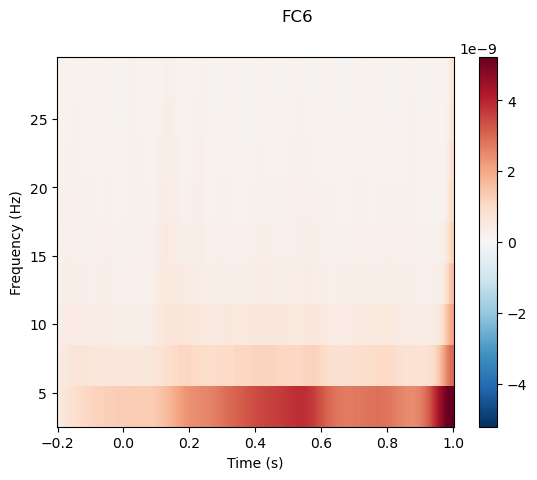

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


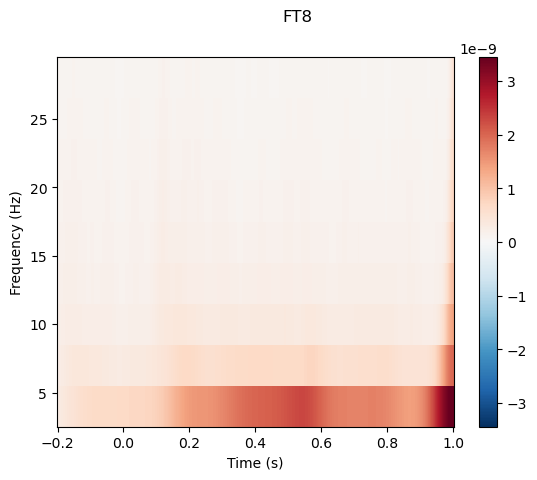

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


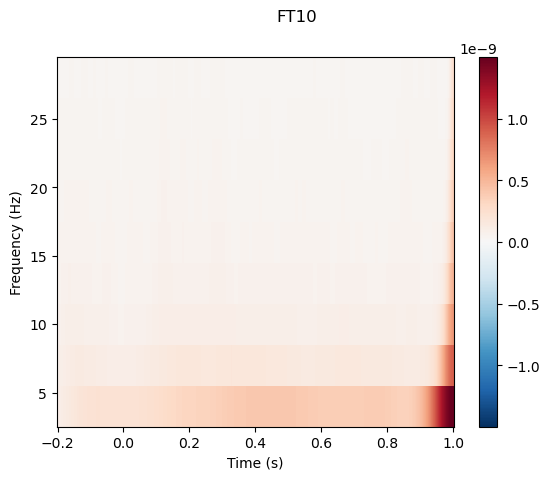

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


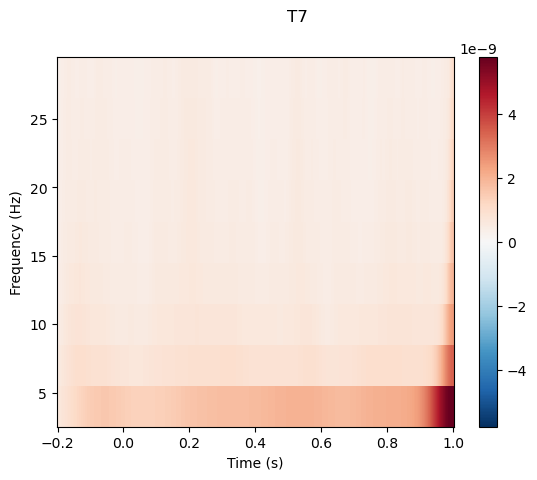

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


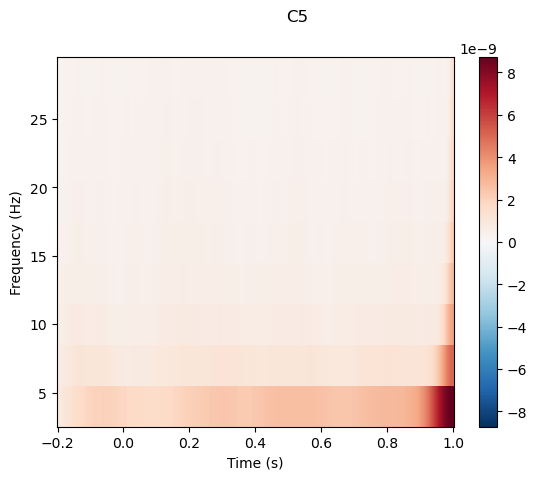

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


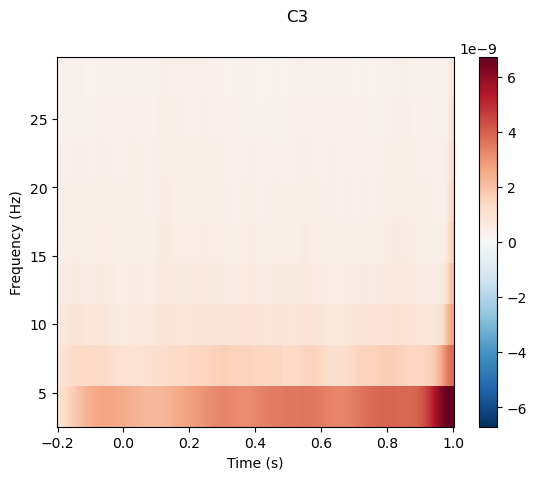

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


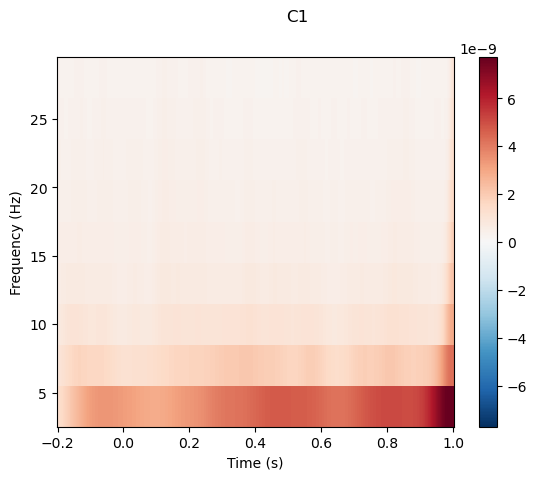

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


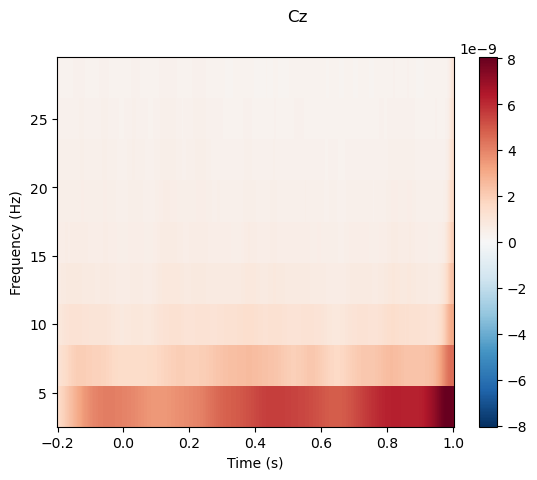

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


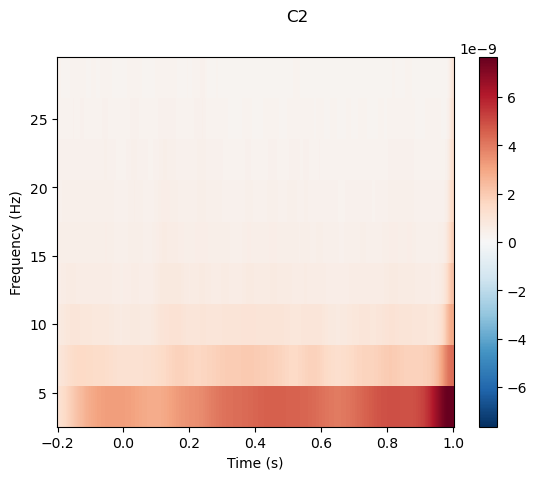

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


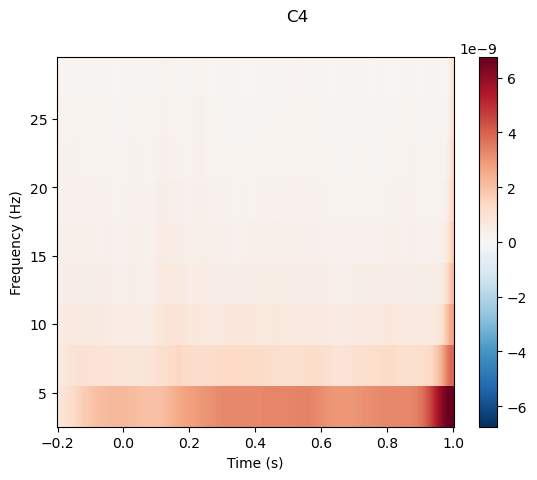

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


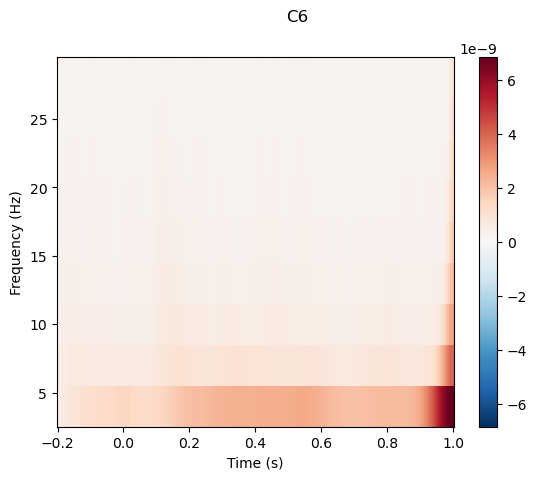

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


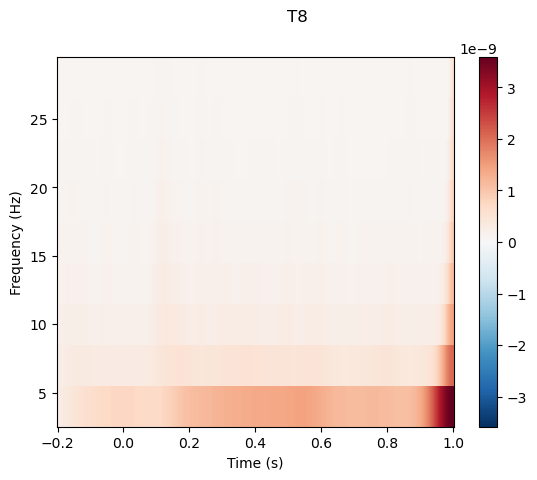

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


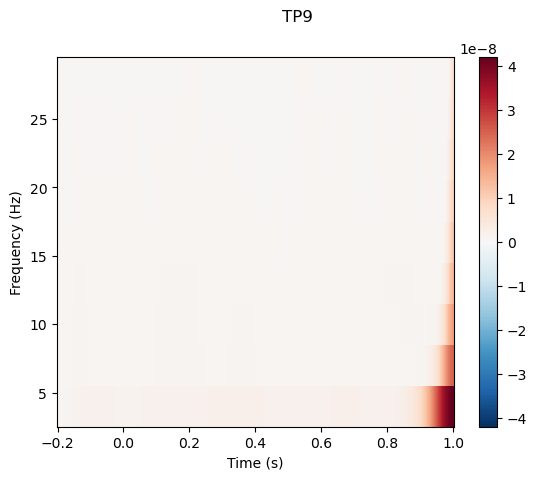

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


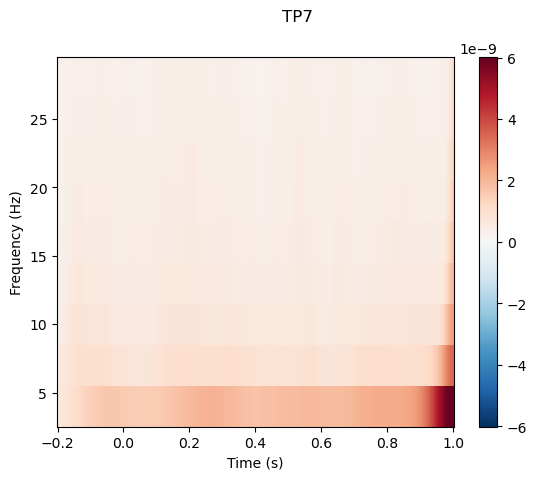

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


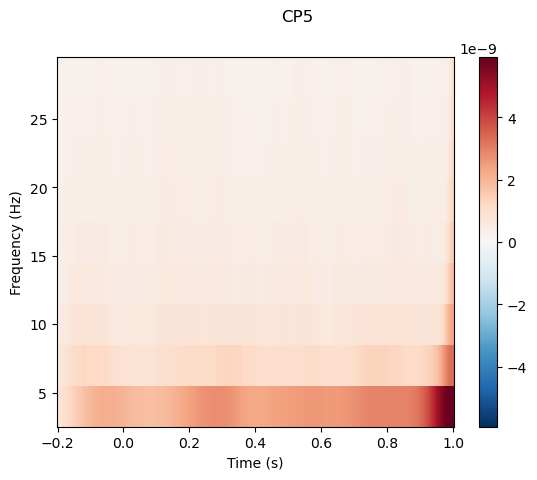

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


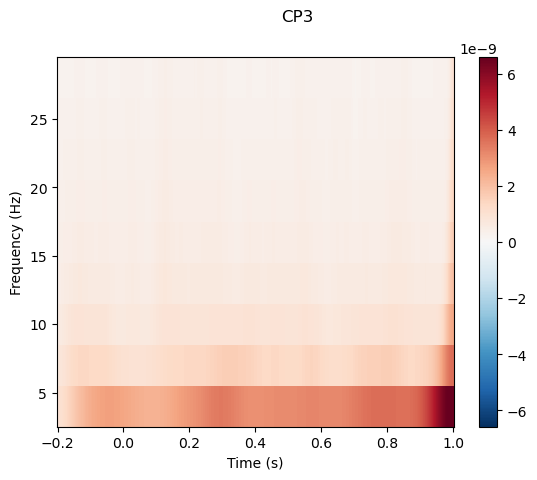

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


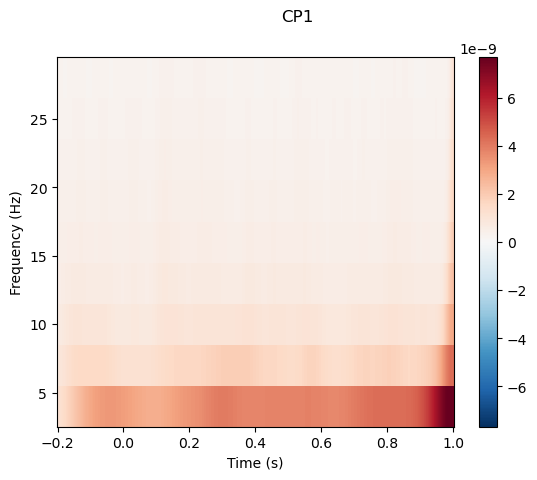

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


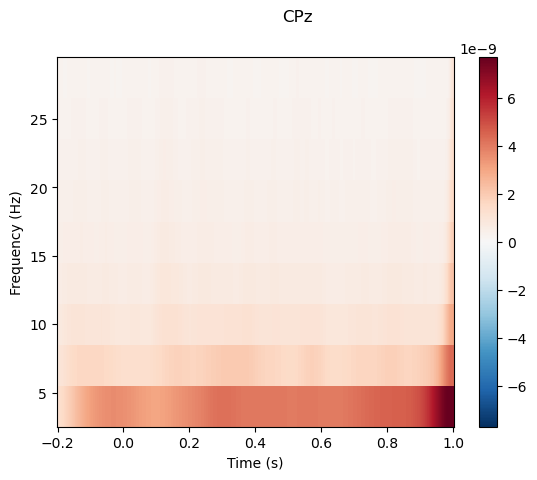

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


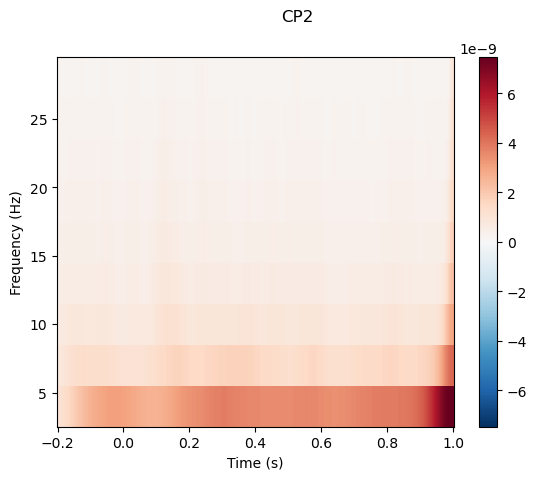

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


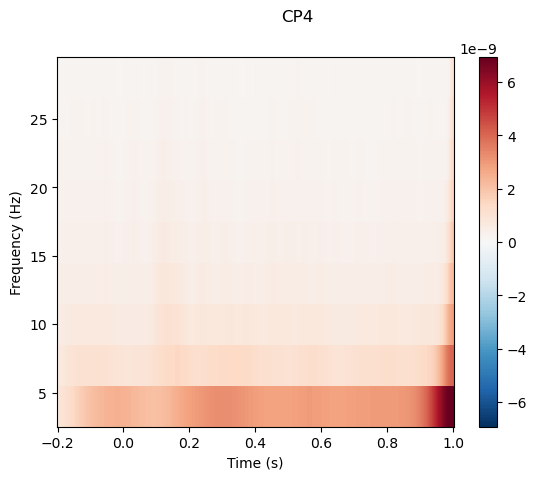

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


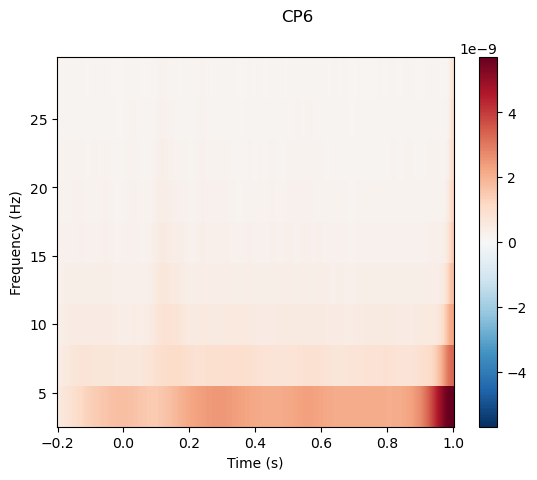

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


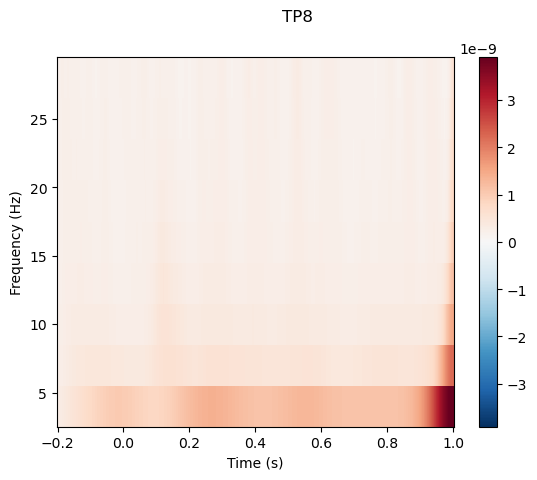

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


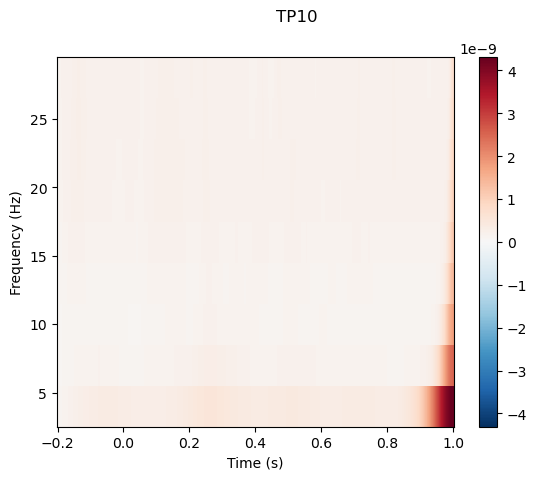

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


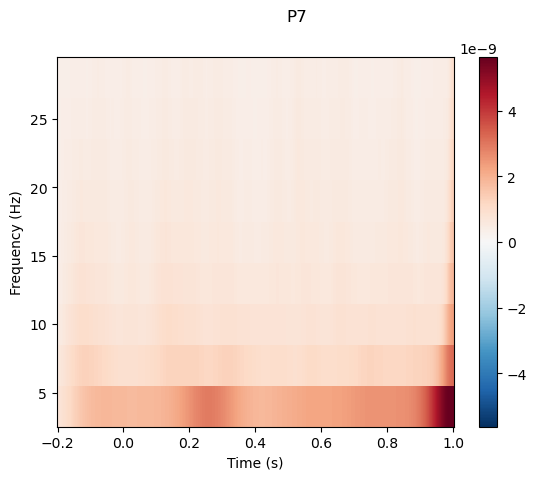

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


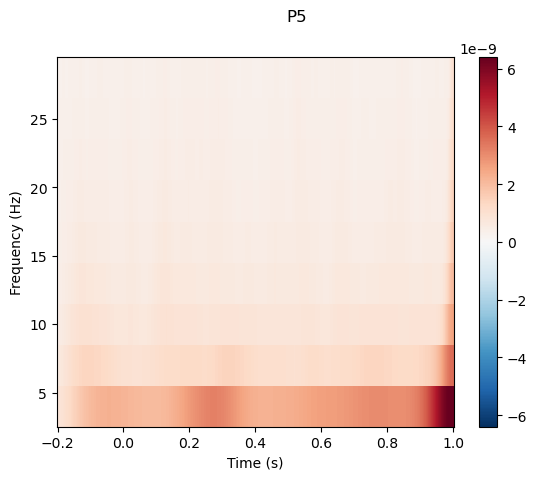

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


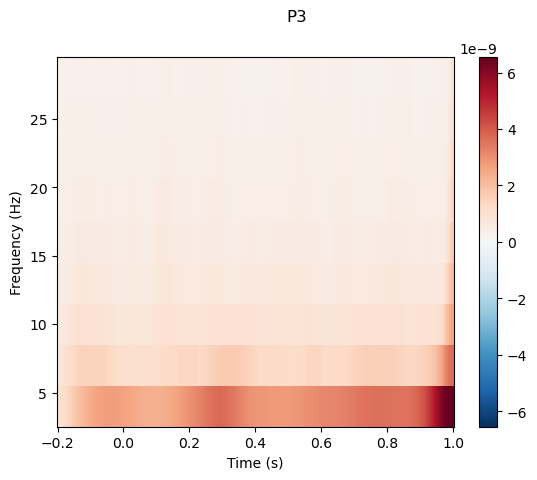

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


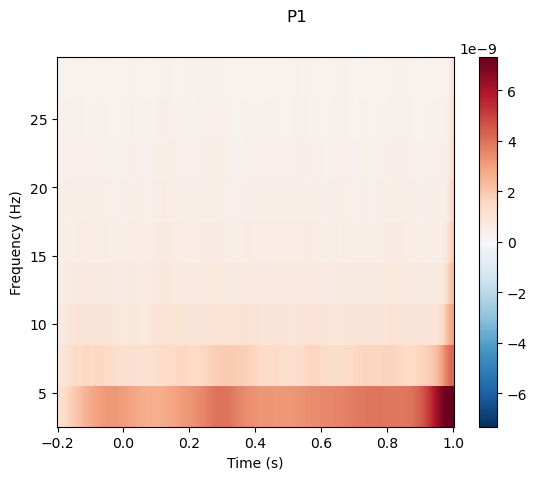

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


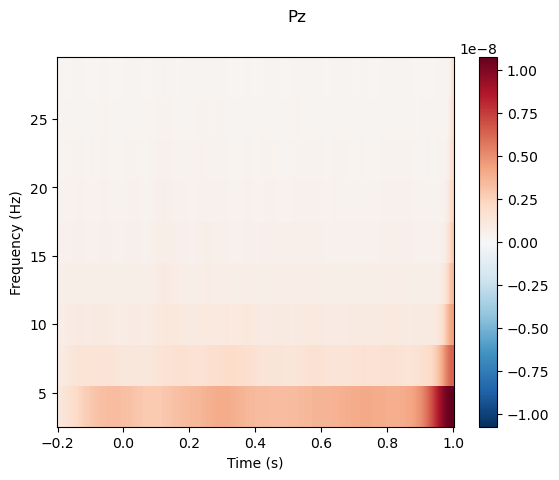

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


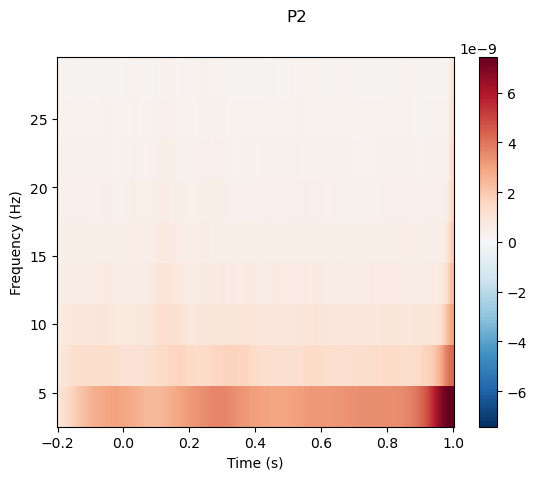

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


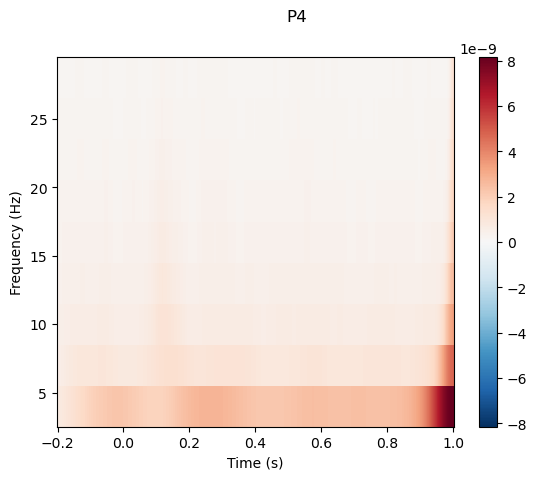

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


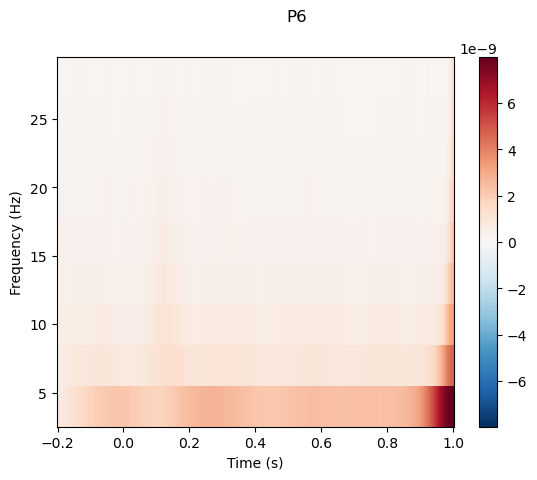

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


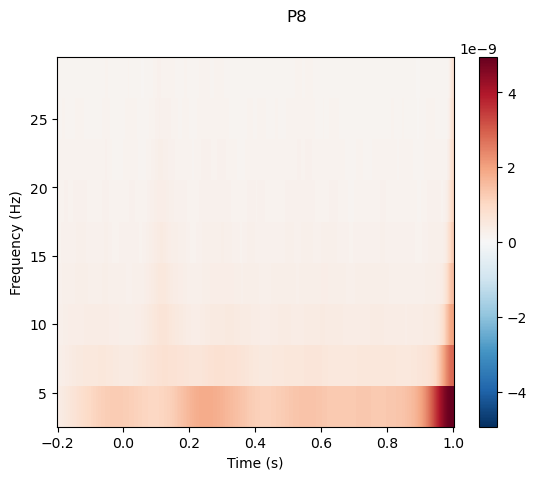

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


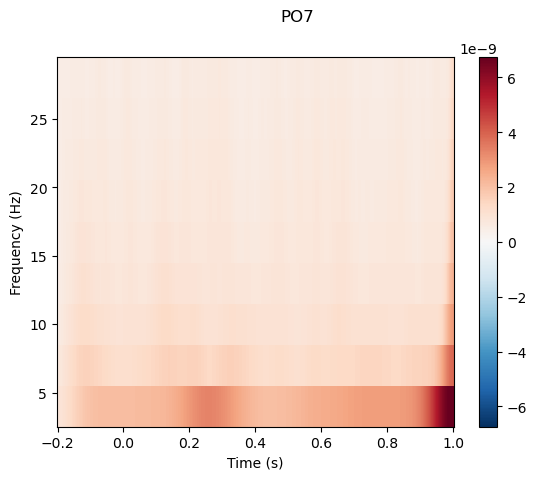

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


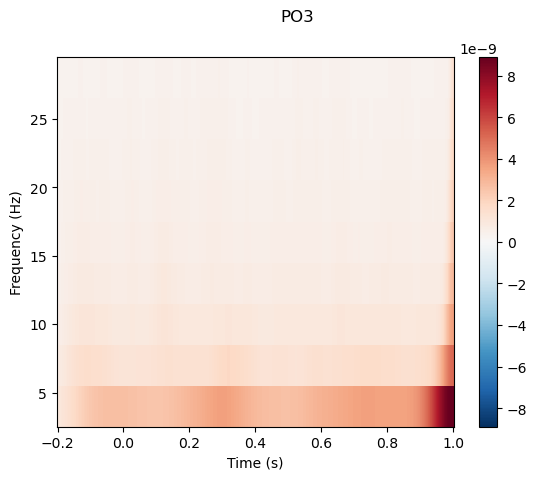

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


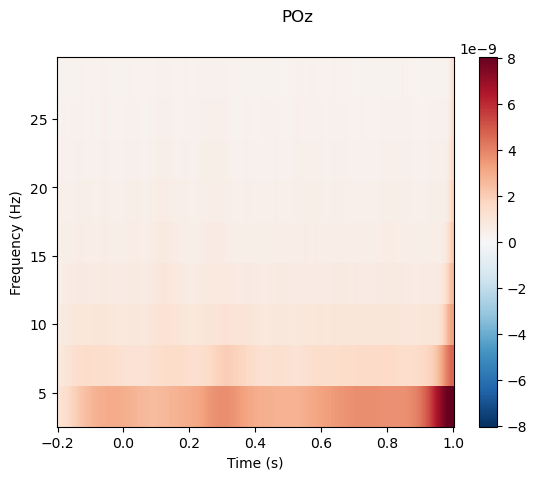

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


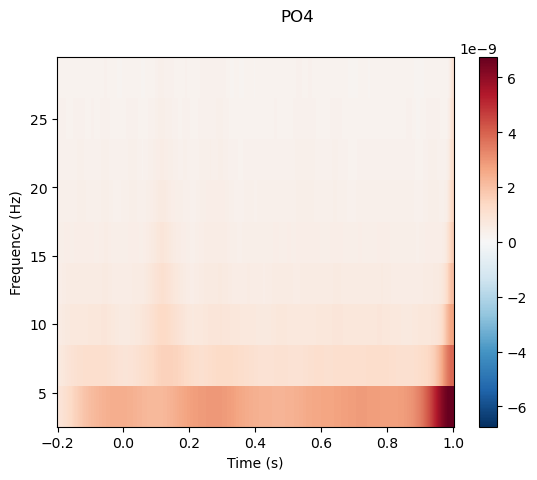

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


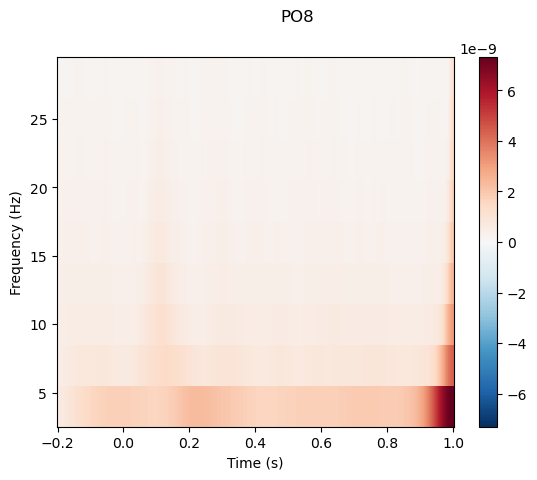

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


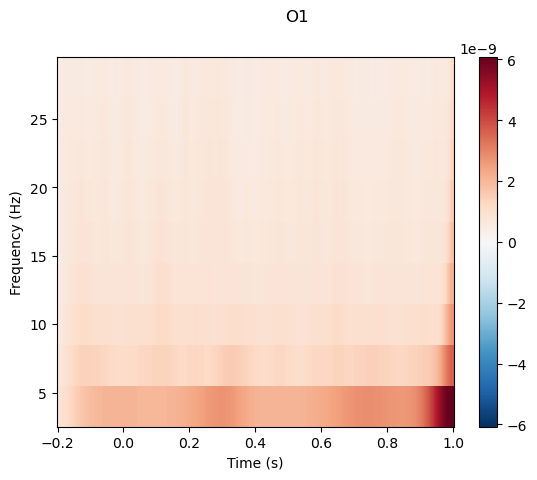

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


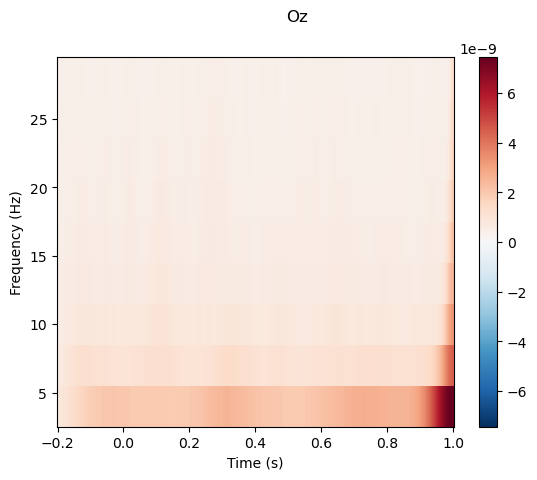

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


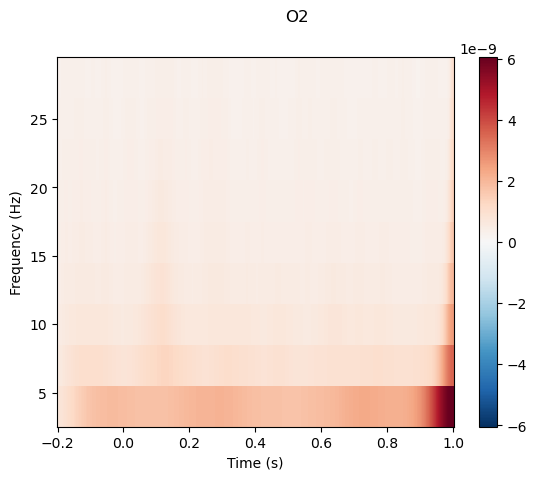

In [43]:
frequencies = np.arange(4, 30, 3)
power = mne.time_frequency.tfr_morlet(epochs, n_cycles=2, return_itc=False, freqs=frequencies, decim=3, average=True)

raw_eeg = reconst_raw.copy().pick_types(eeg=True, eog=False, ecg=False)
ch_name_list = raw_eeg.ch_names

for i in range(len(ch_name_list)):
    ch = ch_name_list[i]
    power.plot(picks = str(ch), title = str(ch))

Effective window size : 1.201 (s)


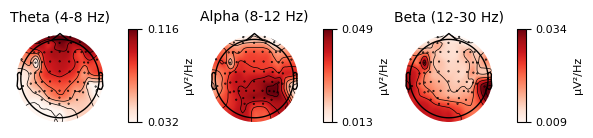

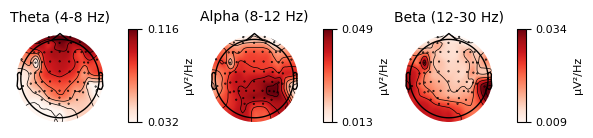

In [44]:
psd_epoch = epochs.compute_psd(method='welch',fmin=4,fmax=30,tmin=-0.2, tmax= 1, picks =['eeg'])
psd_epoch.plot_topomap(bands = {'Theta (4-8 Hz)': (4, 8),'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30)}, normalize = True, ch_type='eeg', agg_fun=np.median)